In [1]:
#global and local morans bivariate
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from esda.moran import Moran, Moran_Local
from libpysal.weights import DistanceBand
from tqdm import tqdm

# Load the CSV file
csv_path = r'C:\Users\Lenovo\ISRO IIRS\finalgridwithvalues1.csv'
df = pd.read_csv(csv_path)

# Drop rows with missing AOD or LST values
df = df.dropna(subset=['AOD_047', 'LST_Kelvin'])

# Create grid geometries with a loading bar
print("Generating grid geometries...")
tqdm.pandas()
df['geometry'] = df.progress_apply(lambda row: box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)

# Convert to GeoDataFrame with a projected CRS for accurate distance calculations
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
gdf = gdf.to_crs('EPSG:3857')  # Project to a metric CRS (Web Mercator)

# Generate spatial weights matrix
print("Generating spatial weights matrix...")
coords = np.array(list(zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y)))
weights = DistanceBand(coords, threshold=2000, binary=True, silence_warnings=True)  # 2000 meters (2 km)

# Standardize variables for Moran's I
z_aod = (gdf['AOD_047'] - gdf['AOD_047'].mean()) / gdf['AOD_047'].std()
z_lst = (gdf['LST_Kelvin'] - gdf['LST_Kelvin'].mean()) / gdf['LST_Kelvin'].std()

# Global Bivariate Moran's I using the cross-product method
print("Calculating global bivariate Moran's I...")
cross_product = z_aod * weights.sparse.dot(z_lst)
global_morans_i = (len(z_aod) / weights.sparse.sum()) * (cross_product.sum() / (z_aod * z_lst).sum())
print(f"Global Bivariate Moran's I: {global_morans_i}")

# Local Bivariate Moran's I
print("Calculating local bivariate Moran's I...")
local_morans_i = Moran_Local(z_aod, weights, transformation="r", permutations=999)

# Add local Moran's I results to the GeoDataFrame
gdf['local_morans_i'] = local_morans_i.Is
gdf['p_value'] = local_morans_i.p_sim
gdf['quadrant'] = local_morans_i.q

# Display results
print("\nLocal Bivariate Moran's I results (first 10 rows):")
print(gdf[['minx', 'miny', 'maxx', 'maxy', 'local_morans_i', 'p_value', 'quadrant']].head(10))







Generating grid geometries...


100%|██████████| 1081/1081 [00:00<00:00, 5555.81it/s]


Generating spatial weights matrix...
Calculating global bivariate Moran's I...
Global Bivariate Moran's I: 0.9773715313437801
Calculating local bivariate Moran's I...

Local Bivariate Moran's I results (first 10 rows):
         minx       miny       maxx       maxy  local_morans_i  p_value  \
0   77.434945  28.622355  77.443945  28.631355        6.045178    0.001   
1   77.443945  28.622355  77.452945  28.631355        5.248553    0.001   
2   77.425945  28.622355  77.434945  28.631355        5.388869    0.001   
3   77.425945  28.631355  77.434945  28.640355        3.723105    0.001   
4   77.434945  28.631355  77.443945  28.640355        4.059122    0.001   
6   77.452945  28.631355  77.461945  28.640355        3.310493    0.001   
7   77.434945  28.640355  77.443945  28.649355        3.233071    0.001   
8   77.452945  28.640355  77.461945  28.649355        3.617114    0.001   
9   77.416945  28.622355  77.425945  28.631355        6.266488    0.001   
10  77.398945  28.622355  77.40

In [5]:
#seeing projection of hsapefile as well as tif files
import geopandas as gpd
import rasterio

# Load the Delhi shapefile and check its CRS
shapefile_path = r'C:\Users\Lenovo\ISRO IIRS\ghaziabad.json'
gdf = gpd.read_file(shapefile_path)
print(gdf.crs)

# Check the CRS of the LST TIFF file
tiff_path = r'C:\Users\Lenovo\ISRO IIRS\lst 1 month oct 2024\new proper delhi lst\MYD11A1.061_LST_Day_1km_doy2024305_aid0001.tif'
with rasterio.open(tiff_path) as src:
    print(src.crs)


EPSG:4326
PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [9]:
#tiff lst to csv
import rasterio
import numpy as np
import pandas as pd
import os
from tqdm import tqdm  # Progress bar

# Folder containing TIFF files
folder_path = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif"  # Change to your folder path
output_folder = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\repro lst csv"  # Folder to save CSVs
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

# Get all TIFF files in the folder
tiff_files = [f for f in os.listdir(folder_path) if f.endswith(".tif")]

# Process each TIFF file
for tiff_file in tqdm(tiff_files, desc="Processing TIFF files"):
    tiff_path = os.path.join(folder_path, tiff_file)

    # Open the TIFF file
    with rasterio.open(tiff_path) as src:
        band1 = src.read(1).astype(float)  # Convert to float
        band1[band1 == 0] = np.nan  # Replace 0 values with NaN (assuming 0 is no-data)
        
        # Apply scale factor
        scale_factor = float(src.tags().get("scale_factor", 1))  # Default 1 if missing
        lst_values = band1 * scale_factor  # Convert to Kelvin
        
        # Get the affine transformation
        transform = src.transform

        # Extract coordinates and LST values
        rows, cols = np.where(~np.isnan(lst_values))  # Get indices of valid data points
        data = []

        for row, col in zip(rows, cols):
            lon, lat = rasterio.transform.xy(transform, row, col)  # Convert pixel to geographic coordinates
            lst_value = lst_values[row, col]
            data.append((lon, lat, lst_value))

    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(data, columns=["Longitude", "Latitude", "LST_Kelvin"])
    csv_filename = os.path.splitext(tiff_file)[0] + "_csv.csv"
    df.to_csv(os.path.join(output_folder, csv_filename), index=False)

print(f"✅ All TIFF files processed and saved in {output_folder}")


Processing TIFF files: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]

✅ All TIFF files processed and saved in C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\repro lst csv


In [23]:
#from json file to csv making 1km grids with 4326 projection

import geopandas as gpd
from shapely.geometry import box
import numpy as np
import pandas as pd

# Load the GeoJSON file for Delhi (update the file path accordingly)
geojson_path = r'C:\Users\Lenovo\ISRO IIRS\ghaziabad.json'
shape = gpd.read_file(geojson_path)

# Set the projection to EPSG:4326 (WGS 84)
shape = shape.to_crs(epsg=4326)

# Get the bounds of the GeoJSON file
minx, miny, maxx, maxy = shape.total_bounds

# Grid size in degrees (approximately 1 km × 1 km)
grid_size = 0.009  # ~1 km at the equator, adjust if needed

# Generate 1 km x 1 km grids using numpy.arange to handle float steps
grid_data = []
for x in np.arange(minx, maxx, grid_size):
    for y in np.arange(miny, maxy, grid_size):
        grid = box(x, y, x + grid_size, y + grid_size)
        grid_data.append([x, y, x + grid_size, y + grid_size, grid])

# Create a GeoDataFrame of the grid
grid_gdf = gpd.GeoDataFrame(grid_data, columns=['minx', 'miny', 'maxx', 'maxy', 'geometry'], crs=shape.crs)

# Clip the grid to the GeoJSON boundary
grid_clipped = gpd.clip(grid_gdf, shape)

# Save the grid data to a CSV file
csv_path = r'C:\Users\Lenovo\ISRO IIRS\imfeelinglucky.csv'
grid_clipped[['minx', 'miny', 'maxx', 'maxy']].to_csv(csv_path, index=False)
print(f"Grid data saved to {csv_path}")

# Output the number of grids
num_grids = len(grid_clipped)
print(f"Total number of 1 km x 1 km grids created: {num_grids}")


Grid data saved to C:\Users\Lenovo\ISRO IIRS\imfeelinglucky.csv
Total number of 1 km x 1 km grids created: 1142


In [19]:
#adds lst and aod to the final grid
import os
import pandas as pd
from tqdm import tqdm

# Input folder paths and grid CSV file path
aod_folder = r'C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\csv aod ghazi'
lst_folder = r'C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\repro lst csv'
grid_csv_path = r'C:\Users\Lenovo\ISRO IIRS\imfeelinglucky.csv'

# Load the grid CSV as a DataFrame
grid_df = pd.read_csv(grid_csv_path)

# Initialize AOD and LST columns
grid_df['AOD_047'] = None
grid_df['LST_Kelvin'] = None

# Function to aggregate values within grid cells with a loading indicator
def aggregate_values_in_grid(csv_folder, value_column, grid_df):
    csv_files = [f for f in os.listdir(csv_folder) if f.lower().endswith('.csv')]
    
    for file_name in tqdm(csv_files, desc=f'Processing {value_column} files', unit='file'):
        file_path = os.path.join(csv_folder, file_name)
        df = pd.read_csv(file_path)
        
        if 'Latitude' in df.columns and 'Longitude' in df.columns and value_column in df.columns:
            for index, grid_cell in grid_df.iterrows():
                minx, miny, maxx, maxy = grid_cell['minx'], grid_cell['miny'], grid_cell['maxx'], grid_cell['maxy']
                
                # Filter points within the grid cell bounds
                points_in_cell = df[
                    (df['Longitude'] >= minx) & (df['Longitude'] <= maxx) &
                    (df['Latitude'] >= miny) & (df['Latitude'] <= maxy)
                ]
                
                if not points_in_cell.empty:
                    grid_df.at[index, value_column] = points_in_cell[value_column].mean()

# Aggregate AOD and LST values into the grid with loading indicators
aggregate_values_in_grid(aod_folder, 'AOD_047', grid_df)
aggregate_values_in_grid(lst_folder, 'LST_Kelvin', grid_df)

# Save the updated grid to a new CSV file
output_csv_path = r'C:\Users\Lenovo\ISRO IIRS\finalgridwithvalues1.csv'
grid_df.to_csv(output_csv_path, index=False)

print(f'\n✅ Final grid file saved as CSV at: {output_csv_path}')


Processing LST_Kelvin files: 100%|██████████| 29/29 [01:59<00:00,  4.11s/file]


✅ Final grid file saved as CSV at: C:\Users\Lenovo\ISRO IIRS\finalgridwithvalues1.csv


In [5]:
# Reprojects LST TIF from sinusoidal to EPSG:4326 with a loading indicator
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from tqdm import tqdm

# Input folder containing TIFF files and the GeoJSON file path
tiff_folder = r'C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif'
geojson_path = r'C:\Users\Lenovo\ISRO IIRS\ghaziabad.json'

# Load the GeoJSON to get the target CRS
gdf = gpd.read_file(geojson_path)
target_crs = gdf.crs

# Get all TIFF files in the folder
tiff_files = [f for f in os.listdir(tiff_folder) if f.lower().endswith('.tif')]

# Iterate through all TIFF files with a progress bar
print("Reprojecting TIFF files...")
for file_name in tqdm(tiff_files, desc="Processing", unit="file"):
    tiff_path = os.path.join(tiff_folder, file_name)
    reprojected_path = os.path.join(tiff_folder, f'reprojected_{file_name}')
    
    with rasterio.open(tiff_path) as src:
        # Calculate the transform and metadata for the reprojection
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Reproject and save to a new file
        with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

print("Reprojection completed!")


Reprojecting TIFF files...


Processing: 100%|██████████| 29/29 [00:26<00:00,  1.11file/s]

Reprojection completed!


In [7]:
#gives rectangle in which json is there to get box for aod data extraction
import geopandas as gpd

# Path to your GeoJSON file
geojson_path = r'C:\Users\Lenovo\ISRO IIRS\ghaziabad.json'

# Load the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Get the bounding box
minx, miny, maxx, maxy = gdf.total_bounds

# SW and NE coordinates
sw = (miny, minx)
ne = (maxy, maxx)

print(f"SW (lat, lon): {sw}")
print(f"NE (lat, lon): {ne}")


SW (lat, lon): (28.622355, 77.200945)
NE (lat, lon): (28.927263, 77.709867)


In [11]:
#hdf file from earthdata aod to csv files 
import os
from pyhdf.SD import SD, SDC
import numpy as np
import pandas as pd
from pyproj import Proj, Transformer
from tqdm import tqdm  # This library provides the progress bar

# === 1. Folder containing HDF files ===
folder_path = r"C:\Users\Lenovo\Downloads\ghazi 2009 oct nov aod"  # Replace with the path to your folder containing HDF files

# Get all HDF files in the folder
hdf_files = [f for f in os.listdir(folder_path) if f.endswith('.hdf')]

# === 2. Loop through each HDF file with Progress Bar ===
for hdf_file in tqdm(hdf_files, desc="Processing HDF files", unit="file"):
    hdf_path = os.path.join(folder_path, hdf_file)
    
    # === 3. Load HDF4 and AOD Data ===
    hdf = SD(hdf_path, SDC.READ)
    aod = hdf.select("Optical_Depth_047")[:].astype(float)

    # === 4. Grid Parameters for 1km ===
    x_dim, y_dim = 1200, 1200
    upper_left_x, upper_left_y = 6671703.118, 3335851.559
    lower_right_x, lower_right_y = 7783653.637667, 2223901.039333

    # === 5. Create X, Y Grids (Sinusoidal Projection) ===
    x_coords = np.linspace(upper_left_x, lower_right_x, x_dim)
    y_coords = np.linspace(upper_left_y, lower_right_y, y_dim)
    xx, yy = np.meshgrid(x_coords, y_coords)

    # === 6. Convert to Latitude/Longitude (New Pyproj Method) ===
    transformer = Transformer.from_crs(
        "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", 
        "+proj=latlong +datum=WGS84", 
        always_xy=True
    )
    flat_lon, flat_lat = transformer.transform(xx.flatten(), yy.flatten())

    # === 7. Flatten AOD Data ===
    flat_aod = aod.flatten()

    # === 8. Ensure Arrays Match in Length ===
    min_length = min(len(flat_lat), len(flat_lon), len(flat_aod))
    flat_lat = flat_lat[:min_length]
    flat_lon = flat_lon[:min_length]
    flat_aod = flat_aod[:min_length]

    # === 9. Save to CSV with Original File Name ===
    # Get the base name of the file without extension
    base_name = os.path.splitext(hdf_file)[0]
    output_csv = os.path.join(folder_path, f"{base_name}-AOD.csv")
    
    # Create DataFrame and save as CSV
    df = pd.DataFrame({"Latitude": flat_lat, "Longitude": flat_lon, "AOD_047": flat_aod})
    df.to_csv(output_csv, index=False)

    print(f"✅ CSV Saved: {output_csv}")

print("All files processed successfully!")

Processing HDF files:   3%|▎         | 1/31 [00:08<04:27,  8.92s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024275.h24v06.061.2024276181918-AOD.csv


Processing HDF files:   6%|▋         | 2/31 [00:24<06:13, 12.88s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024276.h24v06.061.2024277160225-AOD.csv


Processing HDF files:  10%|▉         | 3/31 [00:35<05:32, 11.87s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024277.h24v06.061.2024278162015-AOD.csv


Processing HDF files:  13%|█▎        | 4/31 [00:48<05:34, 12.39s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024278.h24v06.061.2024279163316-AOD.csv


Processing HDF files:  16%|█▌        | 5/31 [01:00<05:16, 12.16s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024279.h24v06.061.2024284003339-AOD.csv


Processing HDF files:  19%|█▉        | 6/31 [01:12<05:03, 12.14s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024280.h24v06.061.2024284044322-AOD.csv


Processing HDF files:  23%|██▎       | 7/31 [01:27<05:12, 13.00s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024281.h24v06.061.2024284093551-AOD.csv


Processing HDF files:  26%|██▌       | 8/31 [01:38<04:48, 12.53s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024282.h24v06.061.2024284170445-AOD.csv


Processing HDF files:  29%|██▉       | 9/31 [01:49<04:23, 11.98s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024283.h24v06.061.2024284191800-AOD.csv


Processing HDF files:  32%|███▏      | 10/31 [02:01<04:15, 12.17s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024284.h24v06.061.2024285232204-AOD.csv


Processing HDF files:  35%|███▌      | 11/31 [02:16<04:14, 12.75s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024285.h24v06.061.2024289175442-AOD.csv


Processing HDF files:  39%|███▊      | 12/31 [02:44<05:34, 17.61s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024286.h24v06.061.2024289203239-AOD.csv


Processing HDF files:  42%|████▏     | 13/31 [03:06<05:40, 18.93s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024287.h24v06.061.2024289204816-AOD.csv


Processing HDF files:  45%|████▌     | 14/31 [03:18<04:47, 16.91s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024288.h24v06.061.2024289210934-AOD.csv


Processing HDF files:  48%|████▊     | 15/31 [03:33<04:18, 16.13s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024289.h24v06.061.2024290170557-AOD.csv


Processing HDF files:  52%|█████▏    | 16/31 [03:45<03:44, 14.97s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024290.h24v06.061.2024291174446-AOD.csv


Processing HDF files:  55%|█████▍    | 17/31 [03:56<03:12, 13.77s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024291.h24v06.061.2024293014506-AOD.csv


Processing HDF files:  58%|█████▊    | 18/31 [04:07<02:47, 12.92s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024292.h24v06.061.2024293211657-AOD.csv


Processing HDF files:  61%|██████▏   | 19/31 [04:19<02:31, 12.63s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024293.h24v06.061.2024294160948-AOD.csv


Processing HDF files:  65%|██████▍   | 20/31 [04:29<02:10, 11.91s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024294.h24v06.061.2024297221512-AOD.csv


Processing HDF files:  68%|██████▊   | 21/31 [04:40<01:54, 11.47s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024295.h24v06.061.2024297224353-AOD.csv


Processing HDF files:  71%|███████   | 22/31 [04:52<01:47, 11.89s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024296.h24v06.061.2024297225937-AOD.csv


Processing HDF files:  74%|███████▍  | 23/31 [05:05<01:36, 12.10s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024297.h24v06.061.2024298165708-AOD.csv


Processing HDF files:  77%|███████▋  | 24/31 [05:19<01:28, 12.62s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024298.h24v06.061.2024299161142-AOD.csv


Processing HDF files:  81%|████████  | 25/31 [05:28<01:10, 11.68s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024299.h24v06.061.2024300160312-AOD.csv


Processing HDF files:  84%|████████▍ | 26/31 [05:43<01:02, 12.52s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024300.h24v06.061.2024301155235-AOD.csv


Processing HDF files:  87%|████████▋ | 27/31 [05:53<00:47, 11.87s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024301.h24v06.061.2024302181458-AOD.csv


Processing HDF files:  90%|█████████ | 28/31 [06:04<00:34, 11.67s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024302.h24v06.061.2024304000518-AOD.csv


Processing HDF files:  94%|█████████▎| 29/31 [06:17<00:23, 11.90s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024303.h24v06.061.2024305033603-AOD.csv


Processing HDF files:  97%|█████████▋| 30/31 [06:27<00:11, 11.44s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024304.h24v06.061.2024306181417-AOD.csv


Processing HDF files: 100%|██████████| 31/31 [06:37<00:00, 12.82s/file]

✅ CSV Saved: C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\MCD19A2.A2024305.h24v06.061.2024306191247-AOD.csv
All files processed successfully!


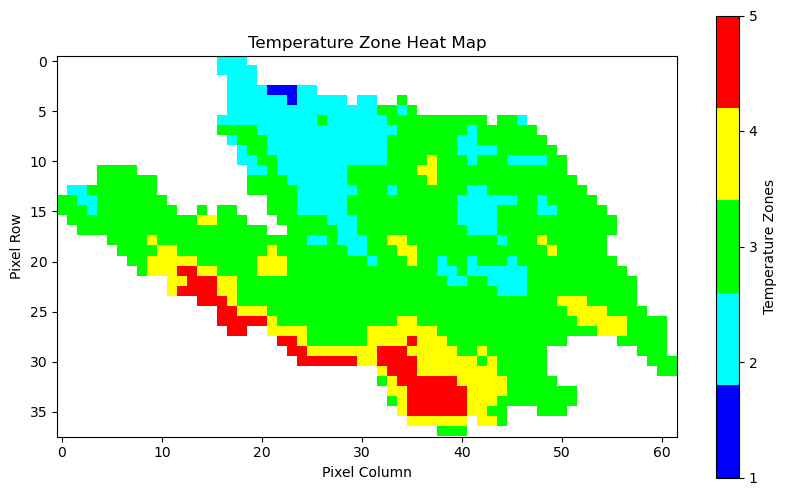

In [3]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Folder containing TIFF files
folder_path = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif"

# MODIS scale factor & offset
SCALE_FACTOR = 0.02
OFFSET = 0

lst_values = []  # Stores all valid LST values for mean & std calculation
pixel_data = {}  # Dictionary to store pixel-wise LST values

# Read all TIFF files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".tif"):
        file_path = os.path.join(folder_path, filename)

        # Open the TIFF file
        with rasterio.open(file_path) as src:
            data = src.read(1).astype(float)  # Read LST band as float
            nodata_value = src.nodata  # Get NoData value from metadata
            height, width = data.shape  # Get raster dimensions

            # Process each pixel
            for row in range(height):
                for col in range(width):
                    raw_value = data[row, col]  # Raw MODIS LST value

                    # Check if value is NULL, NoData, or Zero
                    if (nodata_value is not None and raw_value == nodata_value) or raw_value == 0:
                        continue  # Skip invalid values

                    # Convert raw LST to Celsius
                    lst_celsius = (raw_value * SCALE_FACTOR) - OFFSET - 273.15
                    lst_values.append(lst_celsius)  # Store valid LST values

                    # Store pixel-wise LST values
                    if (row, col) not in pixel_data:
                        pixel_data[(row, col)] = []
                    pixel_data[(row, col)].append(lst_celsius)

# Ensure we have valid LST values before proceeding
if len(lst_values) == 0:
    raise ValueError("No valid LST values found after filtering NULL and zero values.")

# Compute global mean (μ) and standard deviation (σ) of valid LST values
u = np.mean(lst_values)
std = np.std(lst_values)

# Initialize a classification array with NaNs (for invalid pixels)
classification_map = np.full((height, width), np.nan)

# Classify pixels based on Table S1 (only for valid values)
for (row, col), pixel_lst in pixel_data.items():
    T = np.mean(pixel_lst)  # Mean LST for this specific pixel

    if T < u - std:
        level = 1
    elif u - std <= T < u - 0.5 * std:
        level = 2
    elif u - 0.5 * std <= T < u + 0.5 * std:
        level = 3
    elif u + 0.5 * std <= T < u + std:
        level = 4
    else:
        level = 5

    classification_map[row, col] = level

# Define a custom colormap for the heatmap
cmap = ListedColormap([
    '#0000FF',  # Blue for Low Temperature Zone
    '#00FFFF',  # Cyan for Sub Moderate Temperature Zone
    '#00FF00',  # Green for Moderate Temperature Zone
    '#FFFF00',  # Yellow for Sub High Temperature Zone
    '#FF0000'   # Red for High Temperature Zone
])

# Plotting the heat map
plt.figure(figsize=(10, 6))
plt.imshow(classification_map, cmap=cmap, interpolation='none')
plt.colorbar(ticks=[1, 2, 3, 4, 5], label='Temperature Zones')
plt.title('Temperature Zone Heat Map')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()


In [25]:
#coupling coordination
import pandas as pd
import numpy as np

# Load the LST CSV file
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"   # Update with the correct file path
lst_df = pd.read_csv(lst_file)

# Filter out zero and NaN values in LST data
lst_df_filtered = lst_df[(lst_df['LST Value'] > 0) & lst_df['LST Value'].notna()]

# Apply scale factor and convert LST from Kelvin to Celsius
lst_df_filtered['LST Value (Celsius)'] = (lst_df_filtered['LST Value'] * 0.02) - 273.15

# Aggregate LST data by filename (if there are multiple entries for the same filename, calculate average)
lst_df_filtered['Date'] = lst_df_filtered['Filename'].str.extract(r'(\d{4}\d{3})')  # Extracting the date portion
lst_df_avg = lst_df_filtered.groupby('Date')['LST Value (Celsius)'].mean().reset_index()

# Load the PM2.5 CSV file
pm25_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghazi 4 stations pm2.5.csv" # Update with the correct file path
pm25_df = pd.read_csv(pm25_file)

# Convert date columns to the same format as in the LST data (Assuming format is 'YYYYDDD')
pm25_df['Date'] = pd.to_datetime(pm25_df['01-10-2014 00:00'], format='%d-%m-%Y %H:%M')
pm25_df['Date'] = pm25_df['Date'].dt.strftime('%Y%j')  # Format to match LST format

# Filter out zero and NaN values in PM2.5 data
pm25_df_filtered = pm25_df[(pm25_df['194.83'] > 0) & pm25_df['194.83'].notna()]

# Merge the LST and PM2.5 data on 'Date'
merged_df = pd.merge(lst_df_avg, pm25_df_filtered[['Date', '194.83']], on='Date', how='inner')

# Calculate U1 (standardized LST), U2 (standardized PM2.5)
U1 = (merged_df['LST Value (Celsius)'] - merged_df['LST Value (Celsius)'].mean()) / merged_df['LST Value (Celsius)'].std()
U2 = (merged_df['194.83'] - merged_df['194.83'].mean()) / merged_df['194.83'].std()

# Calculate the coupling degree (C)
C = np.sqrt((U1 * U2) / ((U1 + U2) ** 2))

# Calculate the comprehensive coordination index (T)
alpha = 0.5
beta = 0.5
T = alpha * U1 + beta * U2

# Calculate the coupling coordination degree (D)
D = np.sqrt(C * T)

# Add the calculated values to the merged DataFrame
merged_df['Coupling Degree (C)'] = C
merged_df['Comprehensive Index (T)'] = T
merged_df['Coupling Coordination Degree (D)'] = D

# Calculate average of C, T, and D values
average_C = C.mean()
average_T = T.mean()
average_D = D.mean()

# Add averages to the result
averages = pd.DataFrame({
    'Average Coupling Degree (C)': [average_C],
    'Average Comprehensive Index (T)': [average_T],
    'Average Coupling Coordination Degree (D)': [average_D]
})

# Print the results
print(merged_df)
print("\nAverages of C, T, and D:")
print(averages)

# Save the results to a new CSV file
output_file = r"path_to_output_file.csv"  # Update with your desired output file path
merged_df.to_csv(output_file, index=False)

KeyError: 'Filename'

In [9]:
#str of csv file
import pandas as pd

# Load the CSV file
file_path = r'C:\Users\Lenovo\ISRO IIRS\ghaz\ghazi 4 stations pm2.5.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Display the first few rows of the data
print("First 5 rows of the data:")
print(df.head())

# Display information about the structure of the DataFrame
print("\nStructure of the DataFrame:")
print(df.info())

# Display basic statistical details
print("\nStatistical Summary:")
print(df.describe())

# Display the column names
print("\nColumn Names:")
print(df.columns)

# Display data types of each column
print("\nData Types of Each Column:")
print(df.dtypes)


First 5 rows of the data:
          From Date           To Date  PM2.5  PM2.5.1  PM2.5.2  PM2.5.3
0  01-10-2024 00:00  02-10-2024 00:00  74.18   108.32    79.72    70.55
1  02-10-2024 00:00  03-10-2024 00:00  78.81   127.30    87.11    70.64
2  03-10-2024 00:00  04-10-2024 00:00  74.68   110.61    81.46    70.85
3  04-10-2024 00:00  05-10-2024 00:00  75.92    92.98    93.24    76.88
4  05-10-2024 00:00  06-10-2024 00:00  65.70    70.00    56.47    64.34

Structure of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   From Date  31 non-null     object 
 1   To Date    31 non-null     object 
 2   PM2.5      31 non-null     float64
 3   PM2.5.1    31 non-null     float64
 4   PM2.5.2    31 non-null     float64
 5   PM2.5.3    31 non-null     float64
dtypes: float64(4), object(2)
memory usage: 1.6+ KB
None

Statistical Summary:
            

In [13]:
#make 4 pm2.5 into 1 average
import pandas as pd

# Load the CSV file
file_path = r'C:\Users\Lenovo\ISRO IIRS\ghaz\ghazi 4 stations pm2.5.csv'
df = pd.read_csv(file_path)

# Calculate the average of the PM2.5 columns and create a new 'PM2.5' column
df['PM2.5'] = df[['PM2.5', 'PM2.5.1', 'PM2.5.2', 'PM2.5.3']].mean(axis=1)

# Drop the old PM2.5 columns
df = df.drop(columns=['PM2.5.1', 'PM2.5.2', 'PM2.5.3'])

# Save the changes back to the same CSV file (overwrite the file)
df.to_csv(file_path, index=False)

print("CSV file updated successfully!")


CSV file updated successfully!


In [21]:
takes agll lst and makes it verage and converst to c and saves to csv


import rasterio
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Folder containing TIFF files
folder_path = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif"  # Change to your folder path
output_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"

# Get all TIFF files in the folder
tiff_files = [f for f in os.listdir(folder_path) if f.endswith(".tif")]

# List to store results
results = []

# Process each TIFF file
for tiff_file in tqdm(tiff_files, desc="Processing TIFF files"):
    tiff_path = os.path.join(folder_path, tiff_file)

    # Extract date from the file name using DOY (Day of Year)
    try:
        doy = int(tiff_file.split("doy")[1][:7])  # Extract the 'doyYYYYDDD' part
        year = int(str(doy)[:4])
        day_of_year = int(str(doy)[4:])
        
        # Calculate the From and To dates
        from_date = pd.to_datetime(f"{year}-01-01") + pd.DateOffset(days=day_of_year - 1)
        to_date = from_date + pd.DateOffset(days=1)
    except Exception as e:
        print(f"❌ Failed to parse date for file: {tiff_file}. Error: {e}")
        continue

    # Open the TIFF file and calculate the average LST
    with rasterio.open(tiff_path) as src:
        band1 = src.read(1).astype(float)
        
        # Replace 0 and NaN values with NaN for exclusion
        band1[(band1 == 0) | np.isnan(band1)] = np.nan

        # Apply scale factor of 0.02 and convert to Celsius
        lst_values = band1 * 0.02  # Apply scale factor
        lst_values = lst_values - 273.15  # Convert Kelvin to Celsius

        # Calculate the average excluding NaNs
        average_lst = np.nanmean(lst_values)

    # Append the result if average_lst is valid
    if not np.isnan(average_lst):
        results.append([from_date.strftime('%d-%m-%Y'), to_date.strftime('%d-%m-%Y'), average_lst])

# Convert the results to a DataFrame and save to CSV
df = pd.DataFrame(results, columns=["From Date", "To Date", "Average LST (°C)"])
df.to_csv(output_file, index=False)

print(f"✅ All TIFF files processed. Average LST values saved to {output_file}")


Processing TIFF files: 100%|██████████| 29/29 [00:01<00:00, 15.97it/s]

✅ All TIFF files processed. Average LST values saved to C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv


In [27]:
import pandas as pd
import numpy as np

# Load the LST CSV file
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"  
lst_df = pd.read_csv(lst_file)

# Filter out zero and NaN values in LST data
lst_df_filtered = lst_df[(lst_df['LST Value'] > 0) & lst_df['LST Value'].notna()]

# Apply scale factor and convert LST from Kelvin to Celsius
lst_df_filtered['LST Value (Celsius)'] = (lst_df_filtered['LST Value'] * 0.02) - 273.15

# Ensure 'Date' column exists and is correctly formatted
lst_df_filtered['Date'] = pd.to_datetime(lst_df_filtered['Date'], format='%Y%j').dt.strftime('%Y%j')

# Calculate average LST value per date
lst_df_avg = lst_df_filtered.groupby('Date')['LST Value (Celsius)'].mean().reset_index()

# Load the PM2.5 CSV file
pm25_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghazi 4 stations pm2.5.csv" 
pm25_df = pd.read_csv(pm25_file)

# Convert PM2.5 date column to 'YYYYDDD' format
pm25_df['Date'] = pd.to_datetime(pm25_df['01-10-2014 00:00'], format='%d-%m-%Y %H:%M').dt.strftime('%Y%j')

# Filter out zero and NaN values in PM2.5 data
pm25_df_filtered = pm25_df[(pm25_df['194.83'] > 0) & pm25_df['194.83'].notna()]

# Merge the LST and PM2.5 data on 'Date'
merged_df = pd.merge(lst_df_avg, pm25_df_filtered[['Date', '194.83']], on='Date', how='inner')

# Calculate U1 (standardized LST), U2 (standardized PM2.5)
U1 = (merged_df['LST Value (Celsius)'] - merged_df['LST Value (Celsius)'].mean()) / merged_df['LST Value (Celsius)'].std()
U2 = (merged_df['194.83'] - merged_df['194.83'].mean()) / merged_df['194.83'].std()

# Calculate the coupling degree (C)
C = np.sqrt((U1 * U2) / ((U1 + U2) ** 2))

# Calculate the comprehensive coordination index (T)
alpha = 0.5
beta = 0.5
T = alpha * U1 + beta * U2

# Calculate the coupling coordination degree (D)
D = np.sqrt(C * T)

# Add the calculated values to the merged DataFrame
merged_df['Coupling Degree (C)'] = C
merged_df['Comprehensive Index (T)'] = T
merged_df['Coupling Coordination Degree (D)'] = D

# Calculate average of C, T, and D values
average_C = C.mean()
average_T = T.mean()
average_D = D.mean()

# Add averages to the result
averages = pd.DataFrame({
    'Average Coupling Degree (C)': [average_C],
    'Average Comprehensive Index (T)': [average_T],
    'Average Coupling Coordination Degree (D)': [average_D]
})

# Print the results
print(merged_df)
print("\nAverages of C, T, and D:")
print(averages)

# Save the results to a new CSV file
output_file = r"path_to_output_file.csv"  
merged_df.to_csv(output_file, index=False)


KeyError: 'Date'

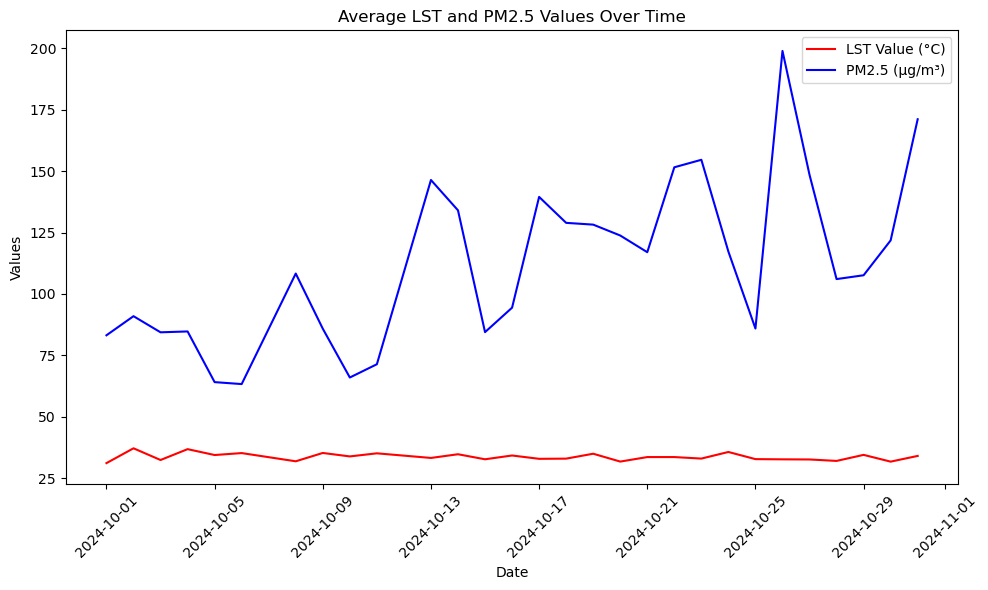

In [31]:
#pm2.5 and lst graph
import pandas as pd
import matplotlib.pyplot as plt

# File paths
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"
pm25_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghazi 4 stations pm2.5.csv"

# Load the CSV files
lst_df = pd.read_csv(lst_file)
pm25_df = pd.read_csv(pm25_file)

# Convert 'From Date' to a proper date format (dd-mm-yyyy)
lst_df['From Date'] = pd.to_datetime(lst_df['From Date'], format='%d-%m-%Y %H:%M')
pm25_df['From Date'] = pd.to_datetime(pm25_df['From Date'], format='%d-%m-%Y %H:%M')

# Calculate average LST value per date
lst_df_avg = lst_df.groupby(lst_df['From Date'].dt.date)['LST Value'].mean().reset_index()
lst_df_avg['From Date'] = pd.to_datetime(lst_df_avg['From Date'])

# Calculate average PM2.5 value per date
pm25_df_avg = pm25_df.groupby(pm25_df['From Date'].dt.date)['PM2.5'].mean().reset_index()
pm25_df_avg['From Date'] = pd.to_datetime(pm25_df_avg['From Date'])

# Merge the datasets on the 'From Date' column
merged_df = pd.merge(lst_df_avg, pm25_df_avg, on='From Date', how='inner')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(merged_df['From Date'], merged_df['LST Value'], label='LST Value (°C)', color='r')
plt.plot(merged_df['From Date'], merged_df['PM2.5'], label='PM2.5 (µg/m³)', color='b')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Average LST and PM2.5 Values Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
#proper coupling coordination
import pandas as pd
import numpy as np

# Load the LST CSV file
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"
lst_df = pd.read_csv(lst_file)

# Filter out zero and NaN values in LST data
lst_df_filtered = lst_df[(lst_df['LST Value'] > 0) & lst_df['LST Value'].notna()]

# Apply scale factor and convert LST from Kelvin to Celsius
lst_df_filtered['LST Value (Celsius)'] = (lst_df_filtered['LST Value'] * 0.02) - 273.15

# Convert 'From Date' to 'YYYYDDD' format
lst_df_filtered['Date'] = pd.to_datetime(lst_df_filtered['From Date'], format='%d-%m-%Y %H:%M').dt.strftime('%Y%j')

# Calculate average LST value per date
lst_df_avg = lst_df_filtered.groupby('Date')['LST Value (Celsius)'].mean().reset_index()

# Load the PM2.5 CSV file
pm25_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghazi 4 stations pm2.5.csv"
pm25_df = pd.read_csv(pm25_file)

# Convert PM2.5 date column to 'YYYYDDD' format
pm25_df['Date'] = pd.to_datetime(pm25_df['From Date'], format='%d-%m-%Y %H:%M').dt.strftime('%Y%j')

# Filter out zero and NaN values in PM2.5 data
pm25_df_filtered = pm25_df[(pm25_df['PM2.5'] > 0) & pm25_df['PM2.5'].notna()]

# Merge the LST and PM2.5 data on 'Date'
merged_df = pd.merge(lst_df_avg, pm25_df_filtered[['Date', 'PM2.5']], on='Date', how='inner')

# Calculate U1 (standardized LST), U2 (standardized PM2.5)
U1 = (merged_df['LST Value (Celsius)'] - merged_df['LST Value (Celsius)'].mean()) / merged_df['LST Value (Celsius)'].std()
U2 = (merged_df['PM2.5'] - merged_df['PM2.5'].mean()) / merged_df['PM2.5'].std()

# Calculate the coupling degree (C)
C = np.sqrt((U1 * U2) / ((U1 + U2) ** 2))

# Calculate the comprehensive coordination index (T)
alpha = 0.5
beta = 0.5
T = alpha * U1 + beta * U2

# Calculate the coupling coordination degree (D)
D = np.sqrt(C * T)

# Add the calculated values to the merged DataFrame
merged_df['Coupling Degree (C)'] = C
merged_df['Comprehensive Index (T)'] = T
merged_df['Coupling Coordination Degree (D)'] = D

# Calculate average of C, T, and D values
average_C = C.mean()
average_T = T.mean()
average_D = D.mean()

# Add averages to the result
averages = pd.DataFrame({
    'Average Coupling Degree (C)': [average_C],
    'Average Comprehensive Index (T)': [average_T],
    'Average Coupling Coordination Degree (D)': [average_D]
})

# Print the results
print(merged_df)
print("\nAverages of C, T, and D:")
print(averages)

# Save the results to a new CSV file
output_file = r"path_to_output_file.csv"
merged_df.to_csv(output_file, index=False)


       Date  LST Value (Celsius)     PM2.5  Coupling Degree (C)  \
0   2024275          -272.526622   83.1925             0.473036   
1   2024276          -272.405984   90.9650                  NaN   
2   2024277          -272.501326   84.4000             0.499942   
3   2024278          -272.412969   84.7550                  NaN   
4   2024279          -272.460790   64.1275                  NaN   
5   2024280          -272.444934   63.3350                  NaN   
6   2024282          -272.511790  108.3175             0.290638   
7   2024283          -272.443982   85.8750                  NaN   
8   2024284          -272.472095   66.0050                  NaN   
9   2024285          -272.446935   71.4075                  NaN   
10  2024287          -272.484522  146.3875                  NaN   
11  2024288          -272.454439  134.0375             0.499417   
12  2024289          -272.495436   84.4750             0.496816   
13  2024290          -272.464565   94.4250                  Na

C:\Users\Lenovo\anaconda77\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load LST CSV
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"
lst_df = pd.read_csv(lst_file)

# Load PM2.5 CSV
pm25_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghazi 4 stations pm2.5.csv"
pm25_df = pd.read_csv(pm25_file)

# Parse 'From Date' in both dataframes
lst_df['From Date'] = pd.to_datetime(lst_df['From Date'], format='%d-%m-%Y %H:%M')
pm25_df['From Date'] = pd.to_datetime(pm25_df['From Date'], format='%d-%m-%Y %H:%M')

# Merge dataframes on 'From Date'
merged_df = pd.merge(lst_df, pm25_df, on='From Date')

# Calculate Pearson correlation
correlation, p_value = pearsonr(merged_df['LST Value'], merged_df['PM2.5'])

print(f'Pearson Correlation: {correlation:.4f}')
print(f'P-Value: {p_value:.4f}')


Pearson Correlation: -0.2669
P-Value: 0.1616


In [31]:
import pandas as pd

# Load LST CSV
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\proper last data.csv"
lst_df = pd.read_csv(lst_file)

# Load PM2.5 CSV
pm25_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\aod 2004 csv\MCD19A2.A2004276.h24v06.061.2022252223427-AOD.csv"
pm25_df = pd.read_csv(pm25_file)

# Function to get all details of a CSV file
def get_csv_details(df, file_name):
    print(f"\n--- {file_name} ---")
    print("\nColumns and Data Types:")
    print(df.dtypes)
    
    print("\nFirst Few Rows:")
    print(df.head())
    
    print("\nSummary Statistics (Numeric Columns):")
    print(df.describe())
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    print("\nColumn Names:")
    print(df.columns)

# Get details of LST CSV
get_csv_details(lst_df, "LST CSV")

# Get details of PM2.5 CSV
get_csv_details(pm25_df, "PM2.5 CSV")



--- LST CSV ---

Columns and Data Types:
minx           float64
miny           float64
maxx           float64
maxy           float64
Average_AOD    float64
Average_LST    float64
dtype: object

First Few Rows:
        minx       miny       maxx       maxy  Average_AOD  Average_LST
0  77.434945  28.622355  77.443945  28.631355     1.161712    32.524226
1  77.443945  28.622355  77.452945  28.631355          NaN    32.870791
2  77.425945  28.622355  77.434945  28.631355          NaN    32.567877
3  77.425945  28.631355  77.434945  28.640355     1.152247    33.713757
4  77.434945  28.631355  77.443945  28.640355     1.175466    33.765667

Summary Statistics (Numeric Columns):
              minx         miny         maxx         maxy  Average_AOD  \
count  1142.000000  1142.000000  1142.000000  1142.000000   965.000000   
mean     77.482569    28.766781    77.491569    28.775781     1.091741   
std       0.121994     0.067607     0.121994     0.067607     0.036945   
min      77.200945    

In [49]:
import pandas as pd

# Load LST CSV
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"
lst_df = pd.read_csv(lst_file)

# Convert LST_Kelvin to Celsius
lst_df['LST_Celsius'] = (lst_df['LST_Kelvin'] * 0.02) - 273.15

# Save the updated DataFrame to a new CSV file
output_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst_celsius.csv"
lst_df.to_csv(output_file, index=False)

print("Conversion complete! New file saved as 'averageghazilst_celsius.csv'.")


KeyError: 'LST_Kelvin'

In [51]:
import pandas as pd

# File path
lst_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst.csv"

# Read the CSV file
lst_df = pd.read_csv(lst_file)

# Print column names to check for typos or hidden characters
print(lst_df.columns)

# Strip whitespace from column names (just in case)
lst_df.columns = lst_df.columns.str.strip()

# Check again to ensure the column exists
if 'LST_Kelvin' in lst_df.columns:
    # Convert LST_Kelvin to Celsius
    lst_df['LST_Celsius'] = (lst_df['LST_Kelvin'] * 0.02) - 273.15
    
    # Save to a new CSV file
    output_file = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\averageghazilst_celsius.csv"
    lst_df.to_csv(output_file, index=False)
    
    print("Conversion successful! New file saved at:", output_file)
else:
    print("Error: 'LST_Kelvin' column not found in the CSV file.")


Index(['From Date', 'To Date', 'LST Value'], dtype='object')
Error: 'LST_Kelvin' column not found in the CSV file.


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Folder paths for LST and PM2.5 CSV files
lst_folder = r"C:\Users\Lenovo\ISRO IIRS\ghaz\ghaz tif\ghaz repro lst tif\repro lst csv"
pm25_folder = r"C:\Users\Lenovo\Downloads\MCD19A2_061-20250224_134218\csv aod ghazi"

# Prepare dataframes to store combined data
lst_data = pd.DataFrame()
pm25_data = pd.DataFrame()

# Read and combine all LST CSV files with a loading indicator
print("Loading LST files...")
for file in tqdm(os.listdir(lst_folder)):
    if file.endswith('.csv'):
        file_path = os.path.join(lst_folder, file)
        df = pd.read_csv(file_path)
        
        # Filter out invalid LST values
        df = df[(df['LST_Kelvin'] > 0) & (df['LST_Kelvin'].notnull())]
        
        lst_data = pd.concat([lst_data, df], ignore_index=True)

# Read and combine all PM2.5 CSV files with a loading indicator
print("\nLoading PM2.5 files...")
for file in tqdm(os.listdir(pm25_folder)):
    if file.endswith('.csv'):
        file_path = os.path.join(pm25_folder, file)
        df = pd.read_csv(file_path)
        
        # Filter out invalid AOD_047 values
        df = df[(df['AOD_047'] > 0) & (df['AOD_047'].notnull())]
        
        pm25_data = pd.concat([pm25_data, df], ignore_index=True)

# Plotting
plt.figure(figsize=(10, 6))

# Plot LST data
ax1 = plt.gca()
ax1.scatter(lst_data['Longitude'], lst_data['LST_Kelvin'], color='red', label='LST (Kelvin)', alpha=0.6)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('LST (Kelvin)', color='red')
ax1.tick_params(axis='y', colors='red')

# Plot PM2.5 data on the secondary Y-axis
ax2 = ax1.twinx()
ax2.scatter(pm25_data['Longitude'], pm25_data['AOD_047'], color='blue', label='AOD 047', alpha=0.6)
ax2.set_ylabel('AOD 047', color='blue')
ax2.tick_params(axis='y', colors='blue')

plt.title('LST (Kelvin) and AOD 047 Values with Dual Y-Axes')
plt.grid(True)
plt.show()


Loading LST files...


100%|██████████| 29/29 [00:00<00:00, 98.30it/s] 



Loading PM2.5 files...


100%|██████████| 31/31 [01:30<00:00,  2.91s/it]


AttributeError: module 'numpy' has no attribute 'matrix'

<Figure size 1000x600 with 2 Axes>

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the data
file_path = r"C:\Users\Lenovo\ISRO IIRS\finalgridwithvalues1.csv"
data = pd.read_csv(file_path)

# Drop rows with missing values
data = data.dropna(subset=['AOD_047', 'LST_Kelvin'])

# Plot AOD vs LST
plt.figure(figsize=(8, 6))
plt.scatter(data['AOD_047'], data['LST_Kelvin'], alpha=0.6, color='teal')
plt.xlabel('AOD 047')
plt.ylabel('LST Kelvin')
plt.title('Scatter Plot of AOD 047 vs LST Kelvin')
plt.grid(True)
plt.show()








AttributeError: module 'numpy' has no attribute 'matrix'

<Figure size 800x600 with 1 Axes>

In [ ]:
import pandas as pd

# Load the CSV file with a flexible delimiter
file_path = r"C:\Users\Lenovo\CSIR NIO\codes sunday\your_data.csv"

# Try different delimiters if needed
data = pd.read_csv(file_path, delimiter=',', error_bad_lines=False, warn_bad_lines=True)

# Display the first few rows to ensure the data is loaded correctly
print(data.head())


In [13]:
import os
from pyhdf.SD import SD, SDC
import numpy as np
import pandas as pd
from pyproj import Transformer
from tqdm import tqdm
import json
from shapely.geometry import Point, shape

# === 1. Folder containing HDF files ===
folder_path = r"C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod"  # Path to your HDF files
geojson_path = r"C:\Users\Lenovo\ISRO IIRS\ghaziabad.json"  # Path to the GeoJSON file

# Load the GeoJSON file
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Convert GeoJSON shapes to Shapely geometries
shapes = [shape(feature['geometry']) for feature in geojson_data['features']]

# Get all HDF files in the folder
hdf_files = [f for f in os.listdir(folder_path) if f.endswith('.hdf')]

# === 2. Loop through each HDF file with Progress Bar ===
for hdf_file in tqdm(hdf_files, desc="Processing HDF files", unit="file"):
    hdf_path = os.path.join(folder_path, hdf_file)
    
    # === 3. Load HDF4 and AOD Data ===
    hdf = SD(hdf_path, SDC.READ)
    aod = hdf.select("Optical_Depth_047")[:].astype(float)

    # === 4. Grid Parameters for 1km ===
    x_dim, y_dim = 1200, 1200
    upper_left_x, upper_left_y = 6671703.118, 3335851.559
    lower_right_x, lower_right_y = 7783653.637667, 2223901.039333

    # === 5. Create X, Y Grids (Sinusoidal Projection) ===
    x_coords = np.linspace(upper_left_x, lower_right_x, x_dim)
    y_coords = np.linspace(upper_left_y, lower_right_y, y_dim)
    xx, yy = np.meshgrid(x_coords, y_coords)

    # === 6. Convert to Latitude/Longitude (New Pyproj Method) ===
    transformer = Transformer.from_crs(
        "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", 
        "+proj=latlong +datum=WGS84", 
        always_xy=True
    )
    flat_lon, flat_lat = transformer.transform(xx.flatten(), yy.flatten())

    # === 7. Flatten AOD Data ===
    flat_aod = aod.flatten()

    # === 8. Ensure Arrays Match in Length ===
    min_length = min(len(flat_lat), len(flat_lon), len(flat_aod))
    flat_lat = flat_lat[:min_length]
    flat_lon = flat_lon[:min_length]
    flat_aod = flat_aod[:min_length]

    # === 9. Filter AOD values (exclude <= 0) ===
    mask = flat_aod > 0
    flat_lat = flat_lat[mask]
    flat_lon = flat_lon[mask]
    flat_aod = flat_aod[mask]

    # === 10. Filter Points Outside GeoJSON Boundary ===
    filtered_data = []
    for lat, lon, aod_val in zip(flat_lat, flat_lon, flat_aod):
        point = Point(lon, lat)
        if any(polygon.contains(point) for polygon in shapes):
            filtered_data.append([lat, lon, aod_val])

    # === 11. Save to CSV with Original File Name ===
    base_name = os.path.splitext(hdf_file)[0]
    output_csv = os.path.join(folder_path, f"{base_name}-AOD.csv")
    
    # Create DataFrame and save as CSV
    df = pd.DataFrame(filtered_data, columns=["Latitude", "Longitude", "AOD_047"])
    df.to_csv(output_csv, index=False)

    print(f"✅ CSV Saved: {output_csv}")

print("All files processed successfully!")


Processing HDF files:   2%|▏         | 1/61 [00:13<13:35, 13.60s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004275.h24v06.061.2022252221652-AOD.csv


Processing HDF files:   3%|▎         | 2/61 [00:15<06:47,  6.91s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004276.h24v06.061.2022252223427-AOD.csv


Processing HDF files:   5%|▍         | 3/61 [00:20<05:43,  5.92s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004277.h24v06.061.2022252225733-AOD.csv


Processing HDF files:   7%|▋         | 4/61 [00:21<03:36,  3.80s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004278.h24v06.061.2022252231725-AOD.csv


Processing HDF files:   8%|▊         | 5/61 [00:44<10:17, 11.03s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004279.h24v06.061.2022252233532-AOD.csv


Processing HDF files:  10%|▉         | 6/61 [01:45<25:26, 27.75s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004280.h24v06.061.2022253000435-AOD.csv


Processing HDF files:  11%|█▏        | 7/61 [02:22<27:49, 30.91s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004281.h24v06.061.2022253001659-AOD.csv


Processing HDF files:  13%|█▎        | 8/61 [03:30<37:39, 42.63s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004282.h24v06.061.2022253003445-AOD.csv


Processing HDF files:  15%|█▍        | 9/61 [03:44<29:19, 33.84s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004283.h24v06.061.2022253005154-AOD.csv


Processing HDF files:  16%|█▋        | 10/61 [04:41<34:45, 40.89s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004284.h24v06.061.2022253012550-AOD.csv


Processing HDF files:  18%|█▊        | 11/61 [04:42<23:49, 28.59s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004285.h24v06.061.2022253014012-AOD.csv


Processing HDF files:  20%|█▉        | 12/61 [05:56<34:40, 42.45s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004286.h24v06.061.2022253015902-AOD.csv


Processing HDF files:  21%|██▏       | 13/61 [07:19<43:54, 54.89s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004287.h24v06.061.2022253021705-AOD.csv


Processing HDF files:  23%|██▎       | 14/61 [08:50<51:30, 65.76s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004288.h24v06.061.2022253024020-AOD.csv


Processing HDF files:  25%|██▍       | 15/61 [10:42<1:00:59, 79.55s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\MCD19A2.A2004289.h24v06.061.2022253025905-AOD.csv


Processing HDF files:  25%|██▍       | 15/61 [11:34<35:29, 46.30s/file]  


KeyboardInterrupt: 

In [19]:
import os
from pyhdf.SD import SD, SDC
import numpy as np
import pandas as pd
from pyproj import Transformer
from tqdm import tqdm
import json
from shapely.geometry import Point, shape

# === 1. Folder containing HDF files ===
folder_path = r"C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod"  # Path to your HDF files
geojson_path = r"C:\Users\Lenovo\ISRO IIRS\ghaziabad.json"  # Path to the GeoJSON file

# Load the GeoJSON file
with open(geojson_path, 'r') as f:
    geojson_data = json.load(f)

# Convert GeoJSON shapes to Shapely geometries
shapes = [shape(feature['geometry']) for feature in geojson_data['features']]

# Get all HDF files in the folder
hdf_files = [f for f in os.listdir(folder_path) if f.endswith('.hdf')]

# === 2. Loop through each HDF file with Progress Bar ===
for hdf_file in tqdm(hdf_files, desc="Processing HDF files", unit="file"):
    hdf_path = os.path.join(folder_path, hdf_file)
    
    # === 3. Load HDF4 and AOD Data ===
    hdf = SD(hdf_path, SDC.READ)
    aod = hdf.select("Optical_Depth_047")[:].astype(float)

    # === 4. Grid Parameters for 1km ===
    x_dim, y_dim = 1200, 1200
    upper_left_x, upper_left_y = 6671703.118, 3335851.559
    lower_right_x, lower_right_y = 7783653.637667, 2223901.039333

    # === 5. Create X, Y Grids (Sinusoidal Projection) ===
    x_coords = np.linspace(upper_left_x, lower_right_x, x_dim)
    y_coords = np.linspace(upper_left_y, lower_right_y, y_dim)
    xx, yy = np.meshgrid(x_coords, y_coords)

    # === 6. Convert to Latitude/Longitude (New Pyproj Method) ===
    transformer = Transformer.from_crs(
        "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext", 
        "+proj=latlong +datum=WGS84", 
        always_xy=True
    )
    flat_lon, flat_lat = transformer.transform(xx.flatten(), yy.flatten())

    # === 7. Flatten AOD Data ===
    flat_aod = aod.flatten()

    # === 8. Ensure Arrays Match in Length ===
    min_length = min(len(flat_lat), len(flat_lon), len(flat_aod))
    flat_lat = flat_lat[:min_length]
    flat_lon = flat_lon[:min_length]
    flat_aod = flat_aod[:min_length]

    # === 9. Filter AOD values (exclude <= 0) ===
    mask = flat_aod > 0
    flat_lat = flat_lat[mask]
    flat_lon = flat_lon[mask]
    flat_aod = flat_aod[mask]

    # === 10. Scale AOD Values ===
    flat_aod = flat_aod * 0.001

    # === 11. Filter Points Outside GeoJSON Boundary ===
    filtered_data = []
    for lat, lon, aod_val in zip(flat_lat, flat_lon, flat_aod):
        point = Point(lon, lat)
        if any(polygon.contains(point) for polygon in shapes):
            filtered_data.append([lat, lon, aod_val])

    # === 12. Save to CSV with Original File Name ===
    base_name = os.path.splitext(hdf_file)[0]
    output_csv = os.path.join(folder_path, f"{base_name}-AOD.csv")
    
    # Create DataFrame and save as CSV
    df = pd.DataFrame(filtered_data, columns=["Latitude", "Longitude", "AOD_047"])
    df.to_csv(output_csv, index=False)

    print(f"✅ CSV Saved: {output_csv}")

print("All files processed successfully!")


Processing HDF files:   2%|▏         | 1/61 [00:55<55:02, 55.04s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009274.h24v06.061.2022323093838-AOD.csv


Processing HDF files:   3%|▎         | 2/61 [00:56<23:02, 23.43s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009275.h24v06.061.2022323103106-AOD.csv


Processing HDF files:   5%|▍         | 3/61 [01:40<31:56, 33.04s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009276.h24v06.061.2022323110243-AOD.csv


Processing HDF files:   7%|▋         | 4/61 [02:02<27:07, 28.55s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009277.h24v06.061.2022323114536-AOD.csv


Processing HDF files:   8%|▊         | 5/61 [02:06<18:15, 19.56s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009278.h24v06.061.2022323122945-AOD.csv


Processing HDF files:  10%|▉         | 6/61 [02:53<26:32, 28.95s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009279.h24v06.061.2022323131235-AOD.csv


Processing HDF files:  11%|█▏        | 7/61 [03:05<21:11, 23.55s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009280.h24v06.061.2022323135815-AOD.csv


Processing HDF files:  13%|█▎        | 8/61 [03:57<28:40, 32.46s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009281.h24v06.061.2022323144532-AOD.csv


Processing HDF files:  15%|█▍        | 9/61 [04:02<20:49, 24.04s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009282.h24v06.061.2022323153306-AOD.csv


Processing HDF files:  16%|█▋        | 10/61 [04:54<27:39, 32.54s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009283.h24v06.061.2022323161206-AOD.csv


Processing HDF files:  18%|█▊        | 11/61 [05:55<34:24, 41.28s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009284.h24v06.061.2022323165623-AOD.csv


Processing HDF files:  20%|█▉        | 12/61 [07:01<39:49, 48.76s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009285.h24v06.061.2022323172126-AOD.csv


Processing HDF files:  21%|██▏       | 13/61 [08:08<43:25, 54.29s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009286.h24v06.061.2022323175849-AOD.csv


Processing HDF files:  23%|██▎       | 14/61 [08:39<36:57, 47.18s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009287.h24v06.061.2022323183755-AOD.csv


Processing HDF files:  25%|██▍       | 15/61 [10:22<49:10, 64.14s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009288.h24v06.061.2022323191903-AOD.csv


Processing HDF files:  26%|██▌       | 16/61 [10:40<37:43, 50.30s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009289.h24v06.061.2022323200126-AOD.csv


Processing HDF files:  28%|██▊       | 17/61 [12:14<46:28, 63.37s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009290.h24v06.061.2022323203609-AOD.csv


Processing HDF files:  30%|██▉       | 18/61 [12:16<32:12, 44.93s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009291.h24v06.061.2022323212917-AOD.csv


Processing HDF files:  31%|███       | 19/61 [13:40<39:39, 56.64s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009292.h24v06.061.2022323220831-AOD.csv


Processing HDF files:  33%|███▎      | 20/61 [15:59<55:34, 81.33s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009293.h24v06.061.2022323225642-AOD.csv


Processing HDF files:  34%|███▍      | 21/61 [17:30<56:07, 84.18s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009294.h24v06.061.2022323233438-AOD.csv


Processing HDF files:  36%|███▌      | 22/61 [20:13<1:10:10, 107.95s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009295.h24v06.061.2022324000511-AOD.csv


Processing HDF files:  38%|███▊      | 23/61 [20:47<54:24, 85.91s/file]   

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009296.h24v06.061.2022324004512-AOD.csv


Processing HDF files:  39%|███▉      | 24/61 [22:18<53:50, 87.30s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009297.h24v06.061.2022324012910-AOD.csv


Processing HDF files:  41%|████      | 25/61 [22:22<37:26, 62.39s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009298.h24v06.061.2022324020350-AOD.csv


Processing HDF files:  43%|████▎     | 26/61 [23:51<41:01, 70.34s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009299.h24v06.061.2022324023929-AOD.csv


Processing HDF files:  44%|████▍     | 27/61 [25:01<39:48, 70.24s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009300.h24v06.061.2022324033414-AOD.csv


Processing HDF files:  46%|████▌     | 28/61 [25:56<36:03, 65.55s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009301.h24v06.061.2022324042352-AOD.csv


Processing HDF files:  48%|████▊     | 29/61 [27:29<39:22, 73.83s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009302.h24v06.061.2022324050839-AOD.csv


Processing HDF files:  49%|████▉     | 30/61 [28:38<37:26, 72.46s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009303.h24v06.061.2022324060547-AOD.csv


Processing HDF files:  51%|█████     | 31/61 [31:25<50:21, 100.70s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009304.h24v06.061.2022324065516-AOD.csv


Processing HDF files:  52%|█████▏    | 32/61 [31:58<38:57, 80.59s/file] 

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009305.h24v06.061.2022324074706-AOD.csv


Processing HDF files:  54%|█████▍    | 33/61 [35:16<54:02, 115.81s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009306.h24v06.061.2022324082154-AOD.csv


Processing HDF files:  56%|█████▌    | 34/61 [35:19<36:50, 81.86s/file] 

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009307.h24v06.061.2022324085243-AOD.csv


Processing HDF files:  57%|█████▋    | 35/61 [37:50<44:29, 102.68s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009308.h24v06.061.2022324092343-AOD.csv


Processing HDF files:  59%|█████▉    | 36/61 [42:13<1:02:47, 150.72s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009309.h24v06.061.2022324095310-AOD.csv


Processing HDF files:  61%|██████    | 37/61 [44:01<55:09, 137.88s/file]  

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009310.h24v06.061.2022324102919-AOD.csv


Processing HDF files:  62%|██████▏   | 38/61 [47:37<1:01:48, 161.25s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009311.h24v06.061.2022324110300-AOD.csv


Processing HDF files:  64%|██████▍   | 39/61 [48:41<48:26, 132.13s/file]  

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009312.h24v06.061.2022324113152-AOD.csv


Processing HDF files:  66%|██████▌   | 40/61 [51:08<47:46, 136.50s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009313.h24v06.061.2022324115745-AOD.csv


Processing HDF files:  67%|██████▋   | 41/61 [51:12<32:13, 96.68s/file] 

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009314.h24v06.061.2022324122821-AOD.csv


Processing HDF files:  69%|██████▉   | 42/61 [51:50<25:07, 79.32s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009315.h24v06.061.2022324132614-AOD.csv


Processing HDF files:  70%|███████   | 43/61 [53:18<24:30, 81.70s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009316.h24v06.061.2022324140733-AOD.csv


Processing HDF files:  72%|███████▏  | 44/61 [53:25<16:51, 59.51s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009317.h24v06.061.2022324151024-AOD.csv


Processing HDF files:  74%|███████▍  | 45/61 [54:35<16:38, 62.42s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009318.h24v06.061.2022324160732-AOD.csv


Processing HDF files:  75%|███████▌  | 46/61 [54:58<12:40, 50.70s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009319.h24v06.061.2022324164311-AOD.csv


Processing HDF files:  77%|███████▋  | 47/61 [58:22<22:33, 96.70s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009320.h24v06.061.2022324171147-AOD.csv


Processing HDF files:  79%|███████▊  | 48/61 [58:38<15:43, 72.58s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009321.h24v06.061.2022324174736-AOD.csv


Processing HDF files:  80%|████████  | 49/61 [1:03:04<26:06, 130.55s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009322.h24v06.061.2022324182519-AOD.csv


Processing HDF files:  82%|████████▏ | 50/61 [1:03:07<16:55, 92.28s/file] 

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009323.h24v06.061.2022324185828-AOD.csv


Processing HDF files:  84%|████████▎ | 51/61 [1:05:38<18:17, 109.77s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009324.h24v06.061.2022324193254-AOD.csv


Processing HDF files:  85%|████████▌ | 52/61 [1:08:44<19:54, 132.77s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009325.h24v06.061.2022324202151-AOD.csv


Processing HDF files:  87%|████████▋ | 53/61 [1:10:51<17:27, 130.95s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009326.h24v06.061.2022324205319-AOD.csv


Processing HDF files:  89%|████████▊ | 54/61 [1:13:43<16:44, 143.49s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009327.h24v06.061.2022324213219-AOD.csv


Processing HDF files:  90%|█████████ | 55/61 [1:14:51<12:04, 120.81s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009328.h24v06.061.2022324215652-AOD.csv


Processing HDF files:  92%|█████████▏| 56/61 [1:18:23<12:20, 148.16s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009329.h24v06.061.2022324222813-AOD.csv


Processing HDF files:  93%|█████████▎| 57/61 [1:18:45<07:21, 110.27s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009330.h24v06.061.2022324225827-AOD.csv


Processing HDF files:  95%|█████████▌| 58/61 [1:22:16<07:01, 140.36s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009331.h24v06.061.2022324235400-AOD.csv


Processing HDF files:  97%|█████████▋| 59/61 [1:25:19<05:06, 153.09s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009332.h24v06.061.2022325010832-AOD.csv


Processing HDF files:  98%|█████████▊| 60/61 [1:26:22<02:06, 126.18s/file]

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009333.h24v06.061.2022325020552-AOD.csv


Processing HDF files: 100%|██████████| 61/61 [1:28:20<00:00, 86.89s/file] 

✅ CSV Saved: C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\MCD19A2.A2009334.h24v06.061.2022325030430-AOD.csv
All files processed successfully!


In [27]:
import pandas as pd
import os
import numpy as np

# Paths to your folders
grid_file = r'C:\Users\Lenovo\ISRO IIRS\imfeelinglucky.csv'  # Update with your grid file path
aod_folder = r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\All 5 years aod filtered csv'  # Update with your AOD folder path
lst_folder = r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\all 5 years lst filtered csv'  # Update with your LST folder path

# Load grid data
grid_data = pd.read_csv(grid_file)

# Load and combine AOD data
aod_data = pd.concat([pd.read_csv(os.path.join(aod_folder, f)) for f in os.listdir(aod_folder) if f.endswith('.csv')])
lst_data = pd.concat([pd.read_csv(os.path.join(lst_folder, f)) for f in os.listdir(lst_folder) if f.endswith('.csv')])

# Initialize new columns for Average AOD and Average LST
grid_data['Average_AOD'] = np.nan
grid_data['Average_LST'] = np.nan

# Iterate over each grid
for index, grid in grid_data.iterrows():
    minx, miny, maxx, maxy = grid['minx'], grid['miny'], grid['maxx'], grid['maxy']
    
    # Filter AOD and LST data within the grid's bounds
    aod_in_grid = aod_data[(aod_data['Longitude'] >= minx) & (aod_data['Longitude'] <= maxx) &
                            (aod_data['Latitude'] >= miny) & (aod_data['Latitude'] <= maxy)]
    
    lst_in_grid = lst_data[(lst_data['Longitude'] >= minx) & (lst_data['Longitude'] <= maxx) &
                            (lst_data['Latitude'] >= miny) & (lst_data['Latitude'] <= maxy)]
    
    # Calculate averages if data exists
    if not aod_in_grid.empty:
        grid_data.at[index, 'Average_AOD'] = aod_in_grid['AOD_047'].mean()
    
    if not lst_in_grid.empty:
        grid_data.at[index, 'Average_LST'] = lst_in_grid['LST_Celsius'].mean()

# Output the result to a new CSV
output_file = 'output_with_average_aod_lst.csv'
grid_data.to_csv(output_file, index=False)
print(f"Output saved to {output_file}")











C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23788\1102123763.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aod_data = pd.concat([pd.read_csv(os.path.join(aod_folder, f)) for f in os.listdir(aod_folder) if f.endswith('.csv')])


AttributeError: module 'numpy' has no attribute 'matrix'

In [29]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm  # For loading indicator

# Paths to your folders
grid_file = r'C:\Users\Lenovo\ISRO IIRS\imfeelinglucky.csv'  
aod_folder = r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\All 5 years aod filtered csv'  
lst_folder = r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\all 5 years lst filtered csv'  

# Load grid data
grid_data = pd.read_csv(grid_file)

# Load and combine AOD and LST data
aod_data = pd.concat([pd.read_csv(os.path.join(aod_folder, f)) for f in os.listdir(aod_folder) if f.endswith('.csv')])
lst_data = pd.concat([pd.read_csv(os.path.join(lst_folder, f)) for f in os.listdir(lst_folder) if f.endswith('.csv')])

# Initialize new columns for Average AOD and Average LST
grid_data['Average_AOD'] = np.nan
grid_data['Average_LST'] = np.nan

# Iterate over each grid with a loading indicator
print("Processing grids with loading indicator...")
for index, grid in tqdm(grid_data.iterrows(), total=len(grid_data)):
    minx, miny, maxx, maxy = grid['minx'], grid['miny'], grid['maxx'], grid['maxy']
    
    # Filter AOD and LST data within the grid's bounds
    aod_in_grid = aod_data[(aod_data['Longitude'] >= minx) & (aod_data['Longitude'] <= maxx) &
                            (aod_data['Latitude'] >= miny) & (aod_data['Latitude'] <= maxy)]
    
    lst_in_grid = lst_data[(lst_data['Longitude'] >= minx) & (lst_data['Longitude'] <= maxx) &
                            (lst_data['Latitude'] >= miny) & (lst_data['Latitude'] <= maxy)]
    
    # Calculate averages if data exists
    if not aod_in_grid.empty:
        grid_data.at[index, 'Average_AOD'] = aod_in_grid['AOD_047'].mean()
    
    if not lst_in_grid.empty:
        grid_data.at[index, 'Average_LST'] = lst_in_grid['LST_Celsius'].mean()

# Output the result to a new CSV
output_file = 'output_with_average_aod_lst.csv'
grid_data.to_csv(output_file, index=False)
print(f"Output saved to {output_file}")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23788\2352229428.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aod_data = pd.concat([pd.read_csv(os.path.join(aod_folder, f)) for f in os.listdir(aod_folder) if f.endswith('.csv')])


AttributeError: module 'numpy' has no attribute 'matrix'

Generating grid geometries...


100%|██████████| 951/951 [00:00<00:00, 15216.00it/s]


Generating spatial weights matrix...
Calculating global bivariate Moran's I...
Global Bivariate Moran's I: 0.22457423161209727
P-value: 0.001
Calculating local bivariate Moran's I...


<Figure size 800x600 with 0 Axes>

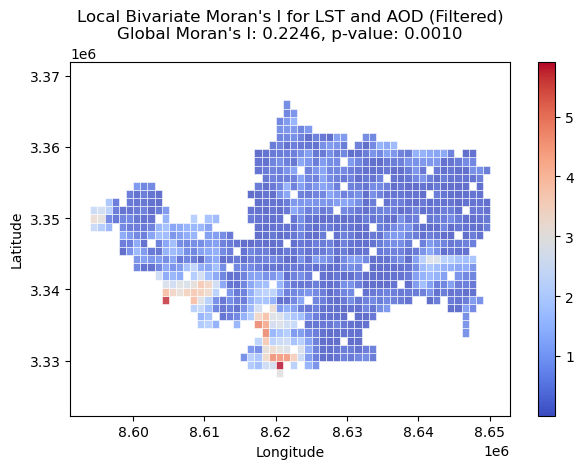

In [1]:
# Global and Local Bivariate Moran's I with Visualization
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from esda.moran import Moran_BV, Moran_Local_BV
from libpysal.weights import DistanceBand
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = r'C:\Users\Lenovo\ISRO IIRS\ghaz\outputwithaverageaodlst2004.csv'
df = pd.read_csv(csv_path)

# Drop rows with missing or zero AOD or LST values
df = df.dropna(subset=['Average_AOD', 'Average_LST'])
df = df[(df['Average_AOD'] != 0) & (df['Average_LST'] != 0)]

# Create grid geometries with a loading bar
print("Generating grid geometries...")
tqdm.pandas()
df['geometry'] = df.progress_apply(lambda row: box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)

# Convert to GeoDataFrame with a projected CRS for accurate distance calculations
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
gdf = gdf.to_crs('EPSG:3857')  # Project to a metric CRS (Web Mercator)

# Generate spatial weights matrix
print("Generating spatial weights matrix...")
coords = np.array(list(zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y)))
weights = DistanceBand(coords, threshold=2000, binary=True, silence_warnings=True)  # 2000 meters (2 km)

# Standardize variables for Moran's I
z_aod = (gdf['Average_AOD'] - gdf['Average_AOD'].mean()) / gdf['Average_AOD'].std()
z_lst = (gdf['Average_LST'] - gdf['Average_LST'].mean()) / gdf['Average_LST'].std()

# Calculate Global Bivariate Moran's I
print("Calculating global bivariate Moran's I...")
global_morans_i = Moran_BV(z_aod, z_lst, weights)
print(f"Global Bivariate Moran's I: {global_morans_i.I}")
print(f"P-value: {global_morans_i.p_sim}")

# Calculate Local Bivariate Moran's I
print("Calculating local bivariate Moran's I...")
local_morans_i = Moran_Local_BV(z_aod, z_lst, weights)

# Add local Moran's I results to the GeoDataFrame
gdf['local_morans_i'] = np.abs(local_morans_i.Is)  # Using absolute values
gdf['p_value'] = local_morans_i.p_sim
gdf['quadrant'] = local_morans_i.q

# Plotting Local Bivariate Moran's I
plt.figure(figsize=(8, 6))
gdf = gdf[gdf['local_morans_i'] != 0]  # Exclude zero Moran's I values

# Plot the grid with local Moran's I values
gdf.plot(column='local_morans_i', cmap='coolwarm', 
         edgecolor='white', linewidth=0.5, 
         legend=True, markersize=30, alpha=0.8)

plt.title(f"Local Bivariate Moran's I for LST and AOD (Filtered)\nGlobal Moran's I: {global_morans_i.I:.4f}, p-value: {global_morans_i.p_sim:.4f}")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [17]:

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from libpysal.weights import KNN
from esda.moran import Moran_BV, Moran_Local_BV
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# File paths for 5 CSV files
data_files = [
    r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2024.csv',
    r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2014.csv',
    r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2004.csv',
    r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2019.csv',
    r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2009.csv'
]

# Set up a consistent color normalization scale
norm = Normalize(vmin=0, vmax=1)

# Prepare a plot with 5 subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)  # Reduce space between subplots

# Loop through files and generate individual plots
for i, file in enumerate(data_files):
    # Load the data
    data = pd.read_csv(file)

    # Drop rows with missing or zero values in Average_AOD or Average_LST
    data = data.dropna(subset=['Average_AOD', 'Average_LST'])
    data = data[(data['Average_AOD'] != 0) & (data['Average_LST'] != 0)]

    # Normalization of Average_AOD (PM2.5) and Average_LST
    data['Z_PM2.5'] = (data['Average_AOD'] - data['Average_AOD'].mean()) / data['Average_AOD'].std()
    data['Z_LST'] = (data['Average_LST'] - data['Average_LST'].mean()) / data['Average_LST'].std()

    # Create square geometries using bounding box coordinates
    data['geometry'] = data.apply(lambda row: box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)
    gdf = gpd.GeoDataFrame(data, geometry='geometry', crs='EPSG:4326')

    # Create spatial weights using K-Nearest Neighbors (k=8) with row standardization
    knn_weights = KNN.from_dataframe(gdf, k=8)
    knn_weights.transform = 'R'  # 'R' is short for 'row-standardized'

    # Calculate Local Bivariate Moran's I
    local_moran_bv = Moran_Local_BV(gdf['Z_PM2.5'], gdf['Z_LST'], knn_weights)

    # Store absolute values of Local Moran's I and cap at 1
    gdf['Local_I_abs'] = np.abs(local_moran_bv.Is)
    gdf['Local_I_abs'] = gdf['Local_I_abs'].apply(lambda x: min(x, 1))

    # Plot on the respective subplot
    ax = axes[i]
    gdf.plot(column='Local_I_abs', cmap='coolwarm', edgecolor='black', linewidth=0.1, 
             legend=False, norm=norm, ax=ax)
    ax.set_title(f'{2004 + 5i}')
    ax.set_xlabel('Longitude')
    if i == 0:
        ax.set_ylabel('Latitude')

# Add a common colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
sm = cm.ScalarMappable(norm=norm, cmap='coolwarm')
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('|Local Moran\'s I|')

plt.suptitle('Local Bivariate Moran\'s I for LST and AOD')
plt.show()



SyntaxError: invalid decimal literal (3597657764.py, line 59)

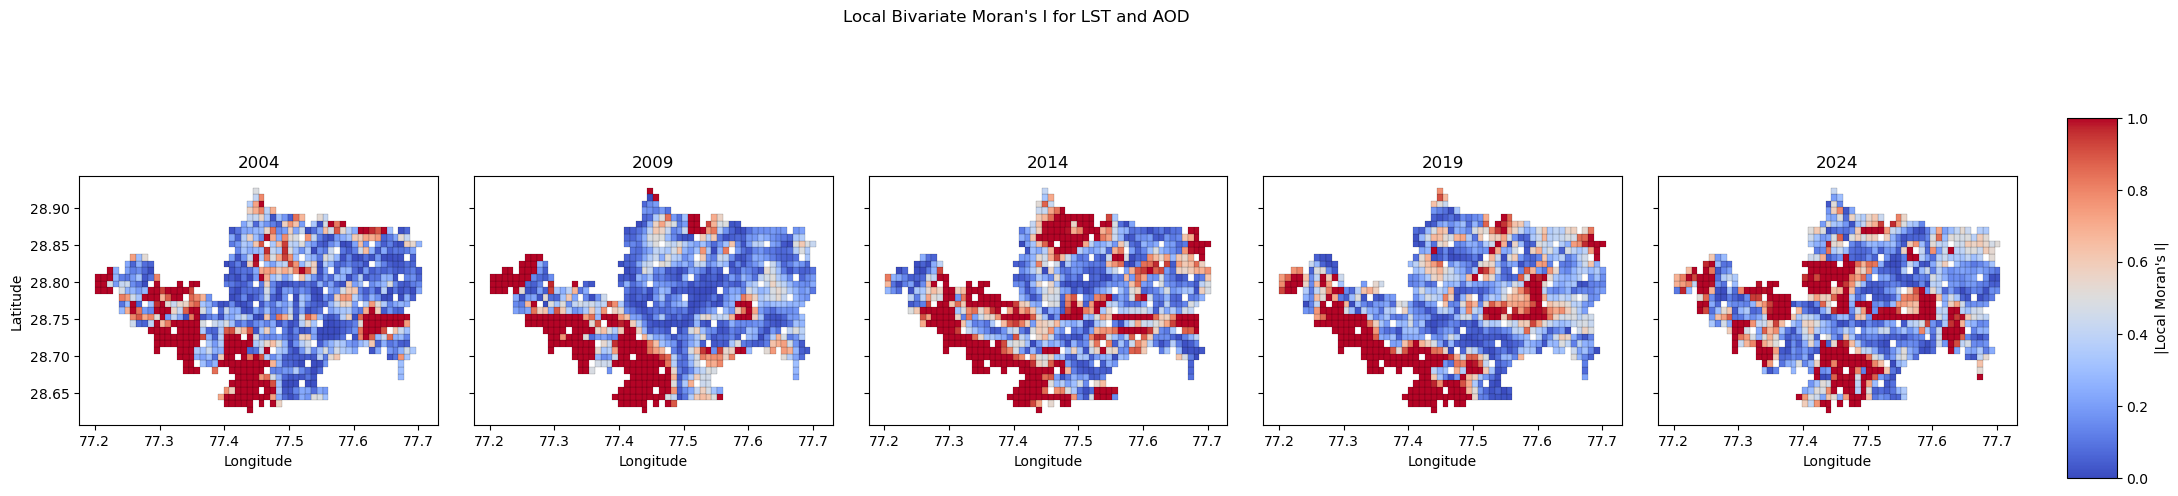

In [19]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from libpysal.weights import KNN
from esda.moran import Moran_BV, Moran_Local_BV
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# File paths for 5 CSV files and their corresponding years
data_files = [
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2004.csv', '2004'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2009.csv', '2009'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2014.csv', '2014'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2019.csv', '2019'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2024.csv', '2024')
]

# Set up a consistent color normalization scale
norm = Normalize(vmin=0, vmax=1)

# Prepare a plot with 5 subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)  # Reduce space between subplots

# Loop through files and generate individual plots
for i, (file, year) in enumerate(data_files):
    # Load the data
    data = pd.read_csv(file)

    # Drop rows with missing or zero values in Average_AOD or Average_LST
    data = data.dropna(subset=['Average_AOD', 'Average_LST'])
    data = data[(data['Average_AOD'] != 0) & (data['Average_LST'] != 0)]

    # Normalization of Average_AOD (PM2.5) and Average_LST
    data['Z_PM2.5'] = (data['Average_AOD'] - data['Average_AOD'].mean()) / data['Average_AOD'].std()
    data['Z_LST'] = (data['Average_LST'] - data['Average_LST'].mean()) / data['Average_LST'].std()

    # Create square geometries using bounding box coordinates
    data['geometry'] = data.apply(lambda row: box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)
    gdf = gpd.GeoDataFrame(data, geometry='geometry', crs='EPSG:4326')

    # Create spatial weights using K-Nearest Neighbors (k=8) with row standardization
    knn_weights = KNN.from_dataframe(gdf, k=8)
    knn_weights.transform = 'R'  # 'R' is short for 'row-standardized'

    # Calculate Local Bivariate Moran's I
    local_moran_bv = Moran_Local_BV(gdf['Z_PM2.5'], gdf['Z_LST'], knn_weights)

    # Store absolute values of Local Moran's I and cap at 1
    gdf['Local_I_abs'] = np.abs(local_moran_bv.Is)
    gdf['Local_I_abs'] = gdf['Local_I_abs'].apply(lambda x: min(x, 1))

    # Plot on the respective subplot
    ax = axes[i]
    gdf.plot(column='Local_I_abs', cmap='coolwarm', edgecolor='black', linewidth=0.1, 
             legend=False, norm=norm, ax=ax)
    ax.set_title(year)
    ax.set_xlabel('Longitude')
    if i == 0:
        ax.set_ylabel('Latitude')

# Add a common colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
sm = cm.ScalarMappable(norm=norm, cmap='coolwarm')
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('|Local Moran\'s I|')

plt.suptitle('Local Bivariate Moran\'s I for LST and AOD')
plt.show()



Reading CSV files from each folder...

Processing 2004...


Processing 2004: 100%|██████████| 51/51 [00:04<00:00, 11.84file/s]



Processing 2009...


Processing 2009: 100%|██████████| 51/51 [00:05<00:00,  9.84file/s]



Processing 2014...


Processing 2014: 100%|██████████| 57/57 [00:06<00:00,  8.85file/s]



Processing 2019...


Processing 2019: 100%|██████████| 49/49 [00:03<00:00, 13.88file/s]



Processing 2024...


Processing 2024: 100%|██████████| 57/57 [00:05<00:00, 11.22file/s]



Global AOD Scale: Min = 27.40, Max = 34.99

Generating heatmaps with consistent color scaling...


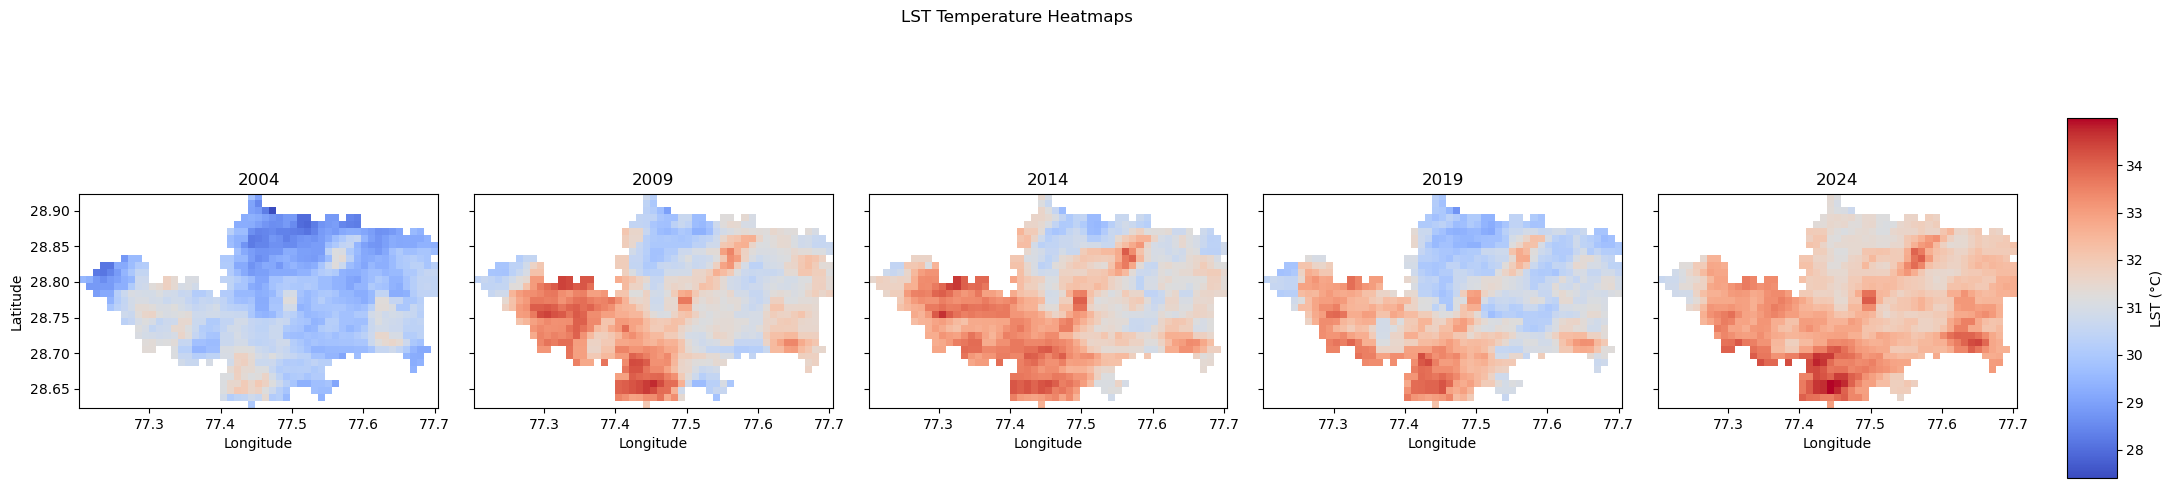

In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # Loading indicator

# === 1. Specify the Folders Containing CSV Files ===
csv_folder_paths = [
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz 2004 lst tifs\reprojected_tif\csv_output',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz 2009 lst tifs\reprojected_tif\csv_output',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz 2014 lst tifs\reprojected_tif\csv_output',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz 2019 lst tifs\reprojected_tif\csv_output',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz 2024 lst tifs\reprojected_tif\csv_output'
]

folder_titles = ['2004', '2009', '2014', '2019', '2024']

# === 2. Prepare variables to hold data for each heatmap ===
avg_pixel_data_list = []  # List of averaged pixel data dictionaries
coordinates_list = []  # List of coordinates
all_avg_aod_values = []  # Store all average AOD values for global scaling

# === 3. Process Each Folder and Read CSV Files ===
print("\nReading CSV files from each folder...")

for folder_path, title in zip(csv_folder_paths, folder_titles):
    print(f"\nProcessing {title}...")
    
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    pixel_data = {}  # Store AOD values for each pixel (for averaging)
    coordinates = []  # Store (lon, lat) for grid creation

    for filename in tqdm(csv_files, desc=f"Processing {title}", unit="file"):
        file_path = os.path.join(folder_path, filename)
        
        # Load CSV into a DataFrame
        df = pd.read_csv(file_path)
        
        # Ensure valid AOD values (filter out NaNs and zeros if needed)
        df = df.dropna(subset=['LST_Celsius'])
        df = df[df['LST_Celsius'] != 0]
        
        for _, row in df.iterrows():
            lon, lat, aod = row['Longitude'], row['Latitude'], row['LST_Celsius']
            
            if (lon, lat) not in pixel_data:
                pixel_data[(lon, lat)] = []
            pixel_data[(lon, lat)].append(aod)
            
            coordinates.append((lon, lat))
    
    # Average AOD values at duplicate coordinates
    avg_pixel_data = {coord: np.mean(values) for coord, values in pixel_data.items()}
    avg_pixel_data_list.append(avg_pixel_data)
    coordinates_list.append(coordinates)
    
    # Collect all average AOD values for global scaling
    all_avg_aod_values.extend(avg_pixel_data.values())

# Ensure there are valid AOD values
if not all_avg_aod_values:
    raise ValueError("No valid AOD values found in the CSV files.")

# === 4. Calculate Global Min and Max of Average AOD Values ===
global_min_aod = min(all_avg_aod_values)
global_max_aod = max(all_avg_aod_values)
print(f"\nGlobal AOD Scale: Min = {global_min_aod:.2f}, Max = {global_max_aod:.2f}")

# === 5. Create a Common Grid for Visualization ===
lons, lats = zip(*[coord for coords in coordinates_list for coord in coords])
lon_min, lon_max = min(lons), max(lons)
lat_min, lat_max = min(lats), max(lats)

# Define grid resolution
resolution = 0.01
grid_lon = np.arange(lon_min, lon_max, resolution)
grid_lat = np.arange(lat_min, lat_max, resolution)

# === 6. Generate Heatmaps with Global Color Scaling in One Row ===
print("\nGenerating heatmaps with consistent color scaling...")

fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)  # Reduce space between subplots

for avg_pixel_data, title, ax in zip(avg_pixel_data_list, folder_titles, axes):
    # Initialize a grid with NaNs
    aod_map = np.full((len(grid_lat), len(grid_lon)), np.nan)
    
    # Fill the grid with averaged AOD values
    for (lon, lat), avg_aod in avg_pixel_data.items():
        col_idx = np.argmin(np.abs(grid_lon - lon))
        row_idx = np.argmin(np.abs(grid_lat - lat))
        aod_map[row_idx, col_idx] = avg_aod
    
    # Plotting the heatmap with global scaling
    im = ax.imshow(aod_map, cmap='coolwarm', interpolation='nearest',
                   extent=[lon_min, lon_max, lat_min, lat_max], origin='lower',
                   vmin=global_min_aod, vmax=global_max_aod)
    
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    if ax == axes[0]:
        ax.set_ylabel('Latitude')

# Add a common colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('LST (°C)')

plt.suptitle('Aerosol Density Maps')
plt.show()



Reading CSV files from each folder...

Processing 2004...


Processing 2004: 100%|██████████| 61/61 [00:03<00:00, 17.58file/s]



Processing 2009...


Processing 2009: 100%|██████████| 61/61 [00:02<00:00, 21.82file/s]



Processing 2014...


Processing 2014: 100%|██████████| 61/61 [00:03<00:00, 18.79file/s]



Processing 2019...


Processing 2019: 100%|██████████| 61/61 [00:01<00:00, 31.08file/s]



Processing 2024...


Processing 2024: 100%|██████████| 61/61 [00:05<00:00, 11.98file/s]



Global AOD Scale: Min = 0.78, Max = 1.47

Generating heatmaps with consistent color scaling...


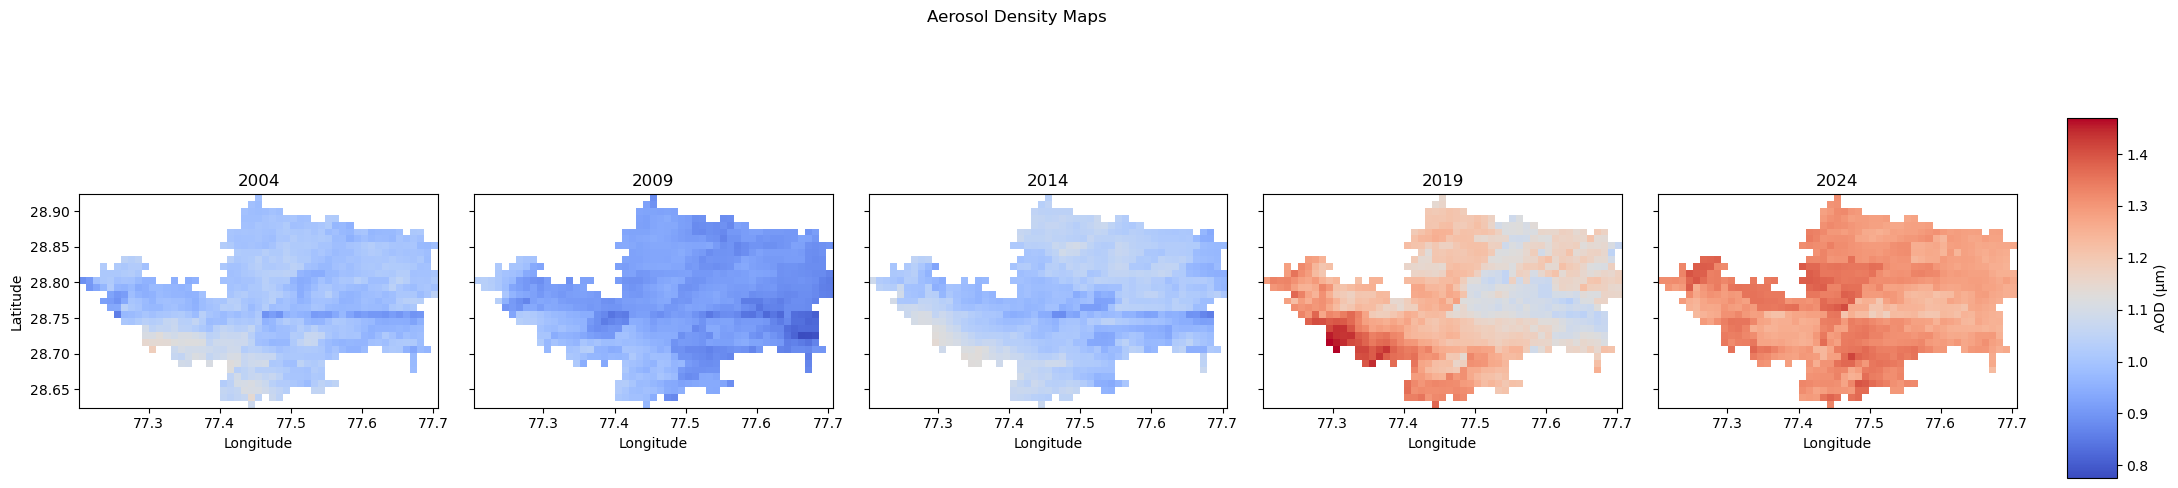

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # Loading indicator

# === 1. Specify the Folders Containing CSV Files ===
csv_folder_paths = [
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2004 oct nov aod\csv aod 2004',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2009 oct nov aod\csv aod 2009',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2014 oct nov aod\csv aod 2014',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2019 oct nov aod\csv aod 2019',
    r'C:\Users\Lenovo\ISRO IIRS\ghaz\Ghaz FINAL Tif lst\ghaz final aod\ghazi 2024 oct nov aod\csv aod 2024'
]

folder_titles = ['2004', '2009', '2014', '2019', '2024']

# === 2. Prepare variables to hold data for each heatmap ===
avg_pixel_data_list = []  # List of averaged pixel data dictionaries
coordinates_list = []  # List of coordinates
all_avg_aod_values = []  # Store all average AOD values for global scaling

# === 3. Process Each Folder and Read CSV Files ===
print("\nReading CSV files from each folder...")

for folder_path, title in zip(csv_folder_paths, folder_titles):
    print(f"\nProcessing {title}...")
    
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    pixel_data = {}  # Store AOD values for each pixel (for averaging)
    coordinates = []  # Store (lon, lat) for grid creation

    for filename in tqdm(csv_files, desc=f"Processing {title}", unit="file"):
        file_path = os.path.join(folder_path, filename)
        
        # Load CSV into a DataFrame
        df = pd.read_csv(file_path)
        
        # Ensure valid AOD values (filter out NaNs and zeros if needed)
        df = df.dropna(subset=['AOD_047'])
        df = df[df['AOD_047'] != 0]
        
        for _, row in df.iterrows():
            lon, lat, aod = row['Longitude'], row['Latitude'], row['AOD_047']
            
            if (lon, lat) not in pixel_data:
                pixel_data[(lon, lat)] = []
            pixel_data[(lon, lat)].append(aod)
            
            coordinates.append((lon, lat))
    
    # Average AOD values at duplicate coordinates
    avg_pixel_data = {coord: np.mean(values) for coord, values in pixel_data.items()}
    avg_pixel_data_list.append(avg_pixel_data)
    coordinates_list.append(coordinates)
    
    # Collect all average AOD values for global scaling
    all_avg_aod_values.extend(avg_pixel_data.values())

# Ensure there are valid AOD values
if not all_avg_aod_values:
    raise ValueError("No valid AOD values found in the CSV files.")

# === 4. Calculate Global Min and Max of Average AOD Values ===
global_min_aod = min(all_avg_aod_values)
global_max_aod = max(all_avg_aod_values)
print(f"\nGlobal AOD Scale: Min = {global_min_aod:.2f}, Max = {global_max_aod:.2f}")

# === 5. Create a Common Grid for Visualization ===
lons, lats = zip(*[coord for coords in coordinates_list for coord in coords])
lon_min, lon_max = min(lons), max(lons)
lat_min, lat_max = min(lats), max(lats)

# Define grid resolution
resolution = 0.01
grid_lon = np.arange(lon_min, lon_max, resolution)
grid_lat = np.arange(lat_min, lat_max, resolution)

# === 6. Generate Heatmaps with Global Color Scaling in One Row ===
print("\nGenerating heatmaps with consistent color scaling...")

fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)  # Reduce space between subplots

for avg_pixel_data, title, ax in zip(avg_pixel_data_list, folder_titles, axes):
    # Initialize a grid with NaNs
    aod_map = np.full((len(grid_lat), len(grid_lon)), np.nan)
    
    # Fill the grid with averaged AOD values
    for (lon, lat), avg_aod in avg_pixel_data.items():
        col_idx = np.argmin(np.abs(grid_lon - lon))
        row_idx = np.argmin(np.abs(grid_lat - lat))
        aod_map[row_idx, col_idx] = avg_aod
    
    # Plotting the heatmap with global scaling
    im = ax.imshow(aod_map, cmap='coolwarm', interpolation='nearest',
                   extent=[lon_min, lon_max, lat_min, lat_max], origin='lower',
                   vmin=global_min_aod, vmax=global_max_aod)
    
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    if ax == axes[0]:
        ax.set_ylabel('Latitude')

# Add a common colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('AOD (µm)')

plt.suptitle('Aerosol Density Maps')
plt.show()


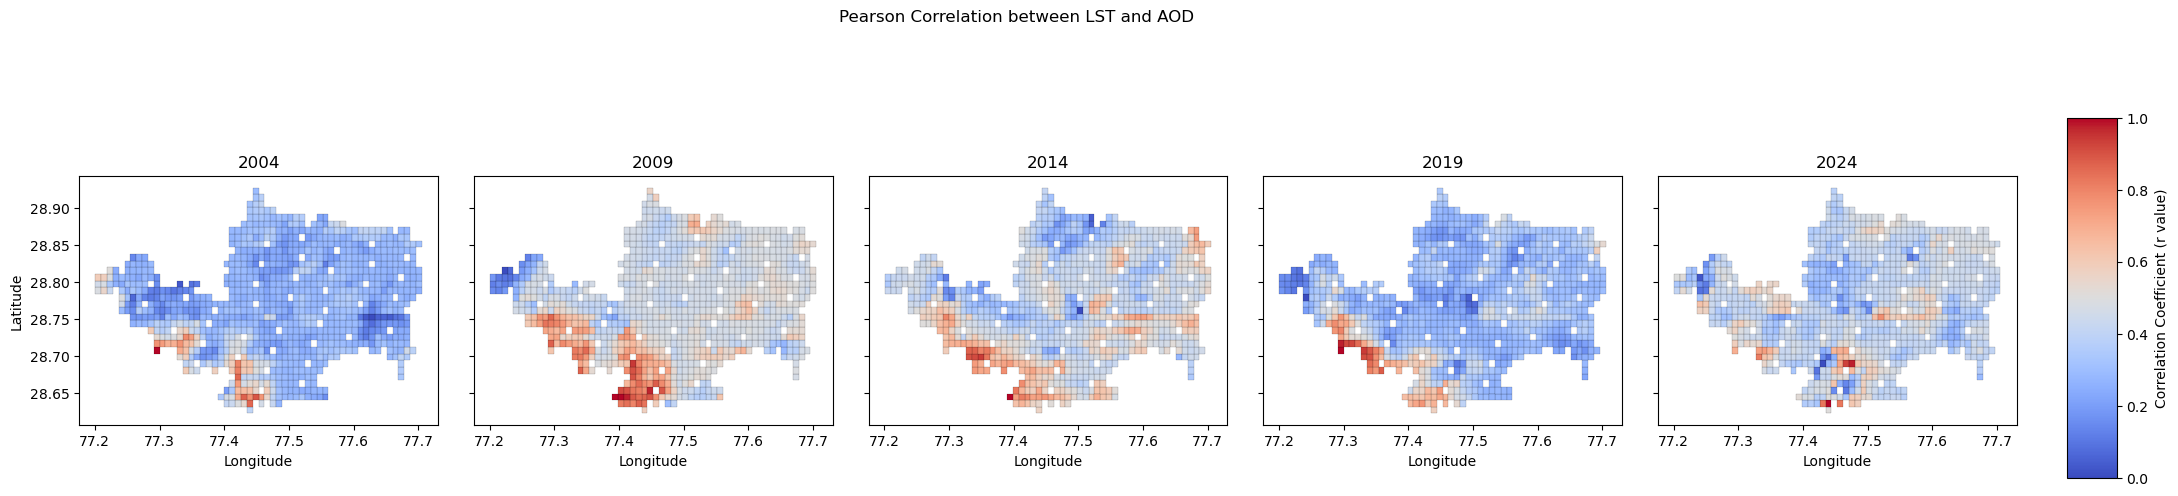

In [33]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from libpysal.weights import KNN
from esda.moran import Moran_BV, Moran_Local_BV
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# File paths for 5 CSV files and their corresponding years
data_files = [
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2004.csv', '2004'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2009.csv', '2009'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2014.csv', '2014'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2019.csv', '2019'),
    (r'C:\Users\Lenovo\ISRO IIRS\outputwithaverageaodlst2024.csv', '2024')
]

# Prepare a plot with 5 subplots in one row
fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1)

# Loop through files and generate individual plots
for i, (file, year) in enumerate(data_files):
    # Load the data
    data = pd.read_csv(file)

    # Drop rows with missing or zero values in Average_AOD or Average_LST
    data = data.dropna(subset=['Average_AOD', 'Average_LST'])
    data = data[(data['Average_AOD'] != 0) & (data['Average_LST'] != 0)]

    # Create square geometries using bounding box coordinates
    data['geometry'] = data.apply(lambda row: box(row['minx'], row['miny'], row['maxx'], row['maxy']), axis=1)
    gdf = gpd.GeoDataFrame(data, geometry='geometry', crs='EPSG:4326')

    # Calculate Pearson correlation
    gdf['Pearson_Corr'] = ((gdf['Average_AOD'] - gdf['Average_AOD'].mean()) * (gdf['Average_LST'] - gdf['Average_LST'].mean())) / (
        np.sqrt(np.sum((gdf['Average_AOD'] - gdf['Average_AOD'].mean())**2)) *
        np.sqrt(np.sum((gdf['Average_LST'] - gdf['Average_LST'].mean())**2))
    )

    # Plot on the respective subplot
    ax = axes[i]
    gdf.plot(column='Pearson_Corr', cmap='coolwarm', edgecolor='black', linewidth=0.1, 
             legend=False, ax=ax)
    ax.set_title(year)
    ax.set_xlabel('Longitude')
    if i == 0:
        ax.set_ylabel('Latitude')

# Add a common colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Position of the colorbar
sm = cm.ScalarMappable(cmap='coolwarm')
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Correlation Coefficient (r value)')

plt.suptitle('Pearson Correlation between LST and AOD')
plt.show()
